# Features selection 

The objective of this notebook is to reveal features which (i) have low or negligible predictive power for the diagnosis; and 2) are redundant to each other.
Several features ranking approach will be tested:

- XGBoost feature importance score, based on 'weight': the number of times a feature is used to split the data across all trees, 'gain': the average gain across all splits the feature is used in, and 'cover': the average coverage across all splits the feature is used in. (See e.g. https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27 for explanations).
- Explainable Boosting Machine importance score, which is for each feature the average of its contrbution to the prediction in absolute value, over all the training data. Another possibility to capture extreme effect would be to take the max() - min() of each graph for instance. 
- Average absolute SHAPley values for each feature.
- Permutation score using Logistic Regression


In [6]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


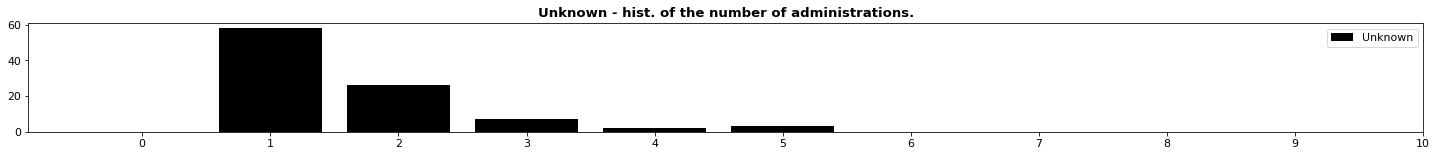

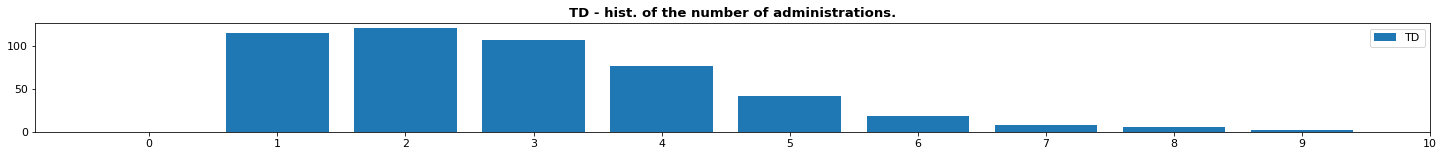

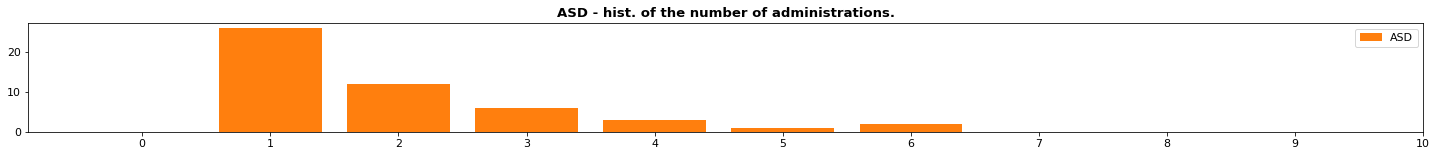

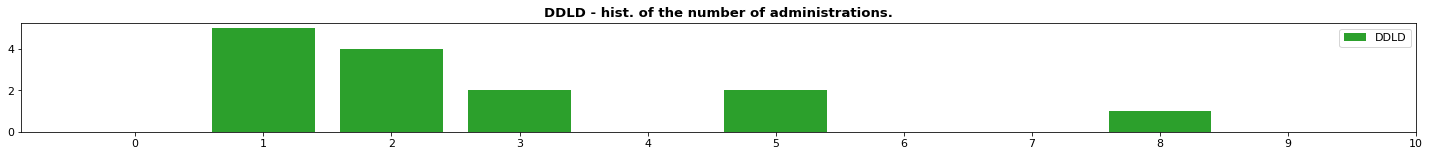

In [158]:
df=data.df
DIAG_DICT = {'Unknown':-1,
             'TD':0., 
            'ASD':1., 
            'DDLD':2., 
            'ADHD':3.}
DIAG_DICT_REVERSE = {v: k for k, v in DIAG_DICT.items()}

colors = {'TD':'#1f77b4',
          'ASD': '#ff7f0e',
          'DDLD':'#2ca02c',
          'ADHD':'#d62728',
          'Unknown': 'k',
          'comorbid':'#9467bd'}


for i, d in data.df.groupby('diagnosis'):
    plt.figure(figsize=(25, 2)), 
    plt.hist(d.groupby("id")['diagnosis'].count().to_numpy(), bins = np.linspace(0, 10 , 11), rwidth=.8,color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    plt.xticks(ticks=np.linspace(0, 10 , 11)+.5, labels=np.linspace(0, 10 , 11).astype(int));plt.legend()
    plt.title("{} - hist. of the number of administrations.".format(DIAG_DICT_REVERSE[i]), weight='bold')
           

# Fitting EBM or XGBoost on the selected dataset

## XGBOOST

In [157]:
DEFAULT_PREDICTORS = [# GAZE RELATED
                   # 'diagnosis',
                     'mean_gaze_percent_right', #aggregated
                     'gaze_silhouette_score', #aggregated

                    # NAME CALL RELATED
                     'proportion_of_name_call_responses',
                     'average_response_to_name_delay',
                   #   'name_call_response_binary',


                    # POSTURAL SWAY RELATED
                     'S_postural_sway',  #aggregated
                     'NS_postural_sway',  #aggregated
                     'S_postural_sway_derivative',
                     'NS_postural_sway_derivative',

                    # TOUCH RELATED
                     'average_length',
                     'std_length',
                     'average_error',
                     #'pop_rate',
                     'average_delay_to_pop',
                     'average_time_spent']

df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='remote',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)

data.filter(administration={'studies': ['ARC', 'P1', 'P2', 'P3'],
                          # 'order': 'first', 
                             'completed': True}, 
                           demographics={'age':[17, 45]}, 
                           clinical={'diagnosis': [0, 1]},
                            verbose=True)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  verbosity=0, 
                  experiment_folder_name='paper_experiment_1_fs',
                  save_experiment=False)


exp.fit_predict('loocv')

display(exp.performances_df)

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.855,0.38,0.859,0.167,0.955,0.458,0.223,0.888,0.386,0.512,0.924,0.389,0.952,0.488,0.611,0.048


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.855,0.38,0.859,0.167,0.955,0.458,0.223,0.888,0.386,0.512,0.924,0.389,0.952,0.488,0.611,0.048


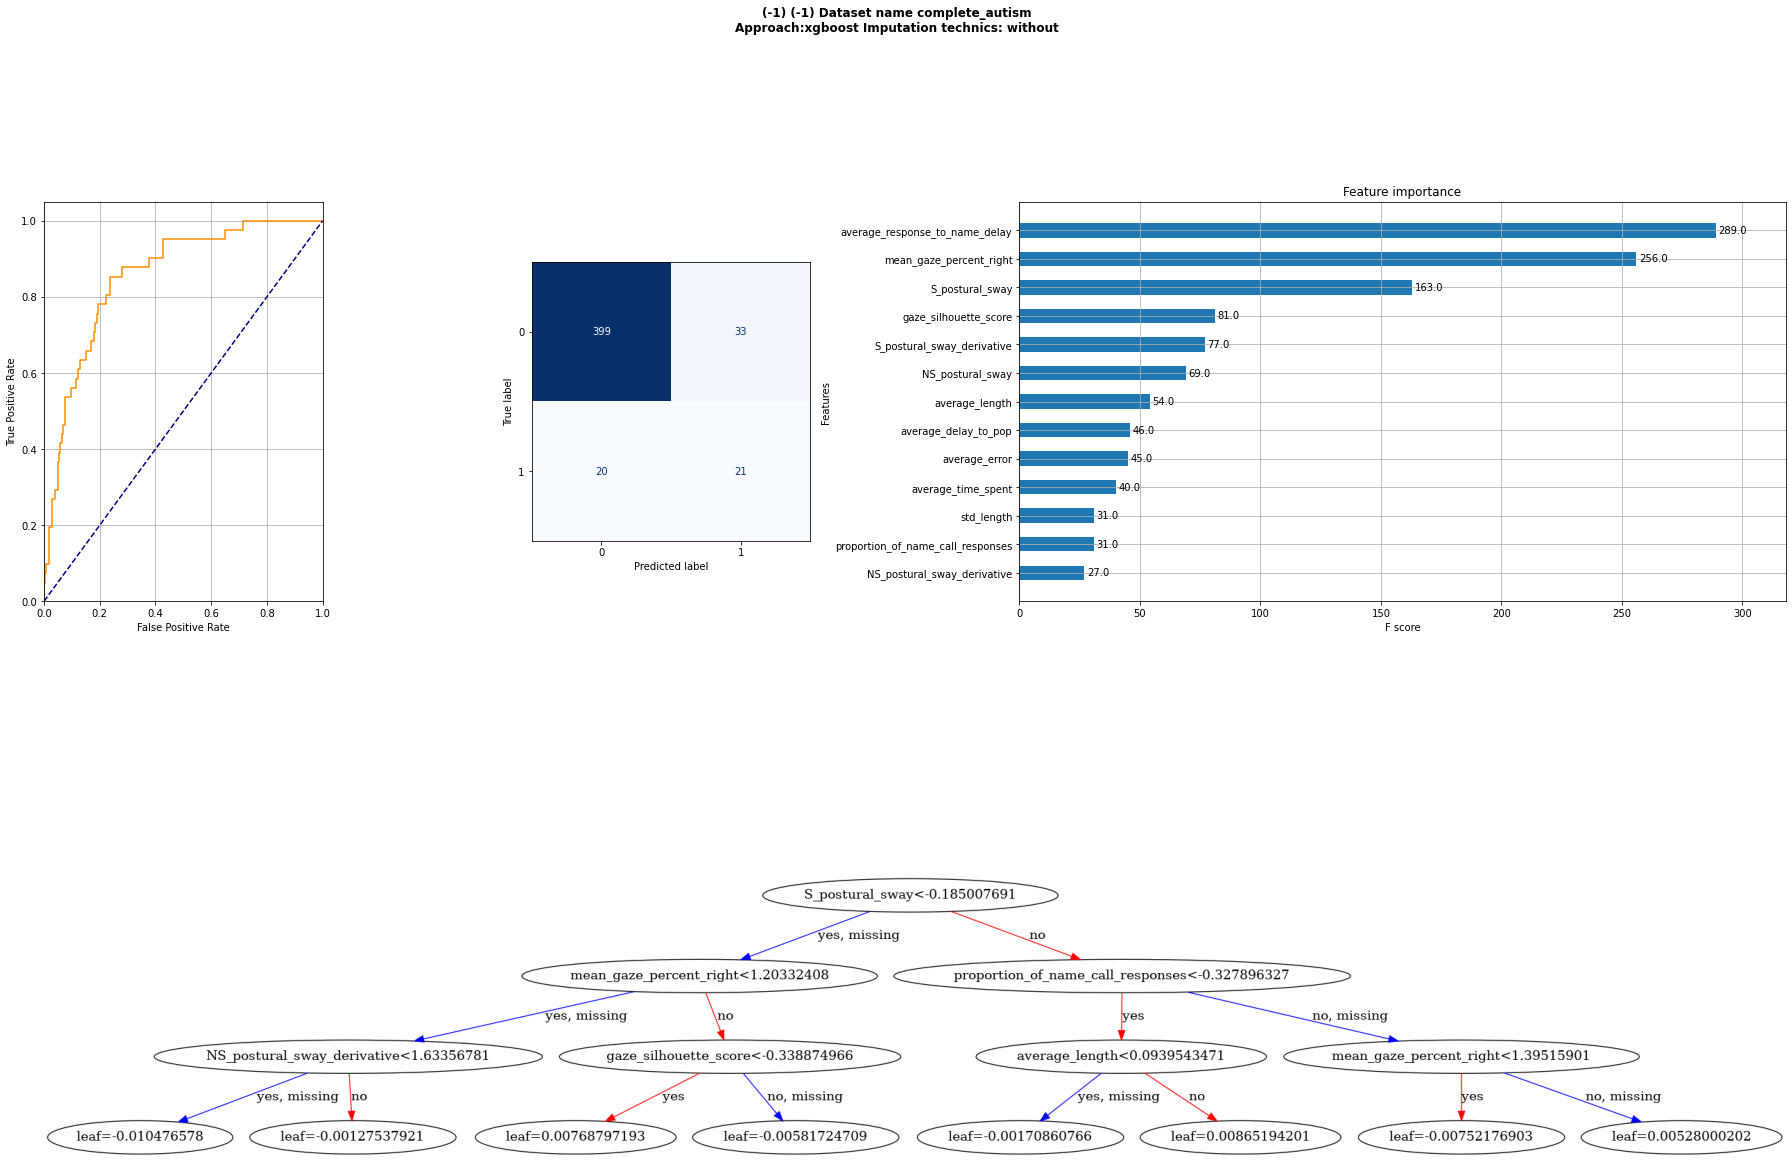

In [155]:
exp.plot()

## Explainable Boosting Machines

In [158]:

df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='remote',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)

data.filter(administration={'studies': ['ARC', 'P1', 'P2', 'P3'],
                          # 'order': 'first', 
                             'completed': True}, 
                           demographics={'age':[17, 45]}, 
                           clinical={'diagnosis': [0, 1]},
                            verbose=True)

exp_ebm = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='ebm', 
                  previous_experiment=None,        
                  debug=False, 
                  verbosity=0, 
                  experiment_folder_name='paper_experiment_1_fs',
                  save_experiment=False)

exp_ebm.fit_predict('loocv')

In [160]:
display(exp_ebm.performances_df)
exp_ebm.predictions_df

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.867,0.379,0.874,0.164,0.946,0.453,0.218,0.875,0.383,0.561,0.905,0.359,0.956,0.439,0.641,0.044


,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,average_length,std_length,average_error,average_delay_to_pop,average_time_spent,y_true,y_pred
0,-1.743893,2.190421,-1.362778,NaN,-0.482703,-0.645332,-0.567212,-0.750375,NaN,NaN,NaN,NaN,NaN,0.0,0.016001
1,0.108148,-0.059836,1.120938,-0.128259,-0.459179,-0.046892,-0.534245,0.673384,-0.310136,-0.306071,-0.617401,-0.315774,-0.482677,0.0,0.010973
2,1.383288,1.254203,-0.534873,-0.073111,-0.509559,-0.184147,-0.563862,0.235356,NaN,NaN,NaN,NaN,NaN,0.0,0.055164
3,-0.457256,-2.240162,1.120938,-1.041259,1.771452,0.457749,2.096574,-0.219299,-0.368095,-0.208299,-0.580625,0.591730,-0.254780,0.0,0.083381
4,-0.587990,0.702651,-1.362778,NaN,-0.255098,-0.056424,-0.177271,0.154211,NaN,NaN,NaN,NaN,NaN,0.0,0.022957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,1.223606,-0.410794,0.293032,-1.304742,-0.443742,-0.386329,-0.503811,0.034981,-0.486896,-0.296419,0.051113,0.153898,0.196520,1.0,0.041057
469,-1.445423,-2.581025,-1.362778,NaN,11.866719,0.485602,6.637179,0.379478,-0.779691,-0.663928,4.093553,-2.732687,-0.949987,0.0,0.451948
470,2.395104,-1.831066,-0.534873,-1.029004,0.903583,1.984227,0.802754,0.713101,-0.797688,-0.704282,0.807182,4.141893,-0.997282,0.0,0.787023
471,-1.084955,-1.556437,-1.362778,NaN,1.659635,-0.296391,1.941972,-0.373197,0.091249,0.465364,-0.785806,0.246048,NaN,0.0,0.122105


In [161]:
print("Results for XGBOOST")
display(exp.performances_df)
print("Results for EBM")
display(exp_ebm.performances_df)


Results for XGBOOST


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.855,0.38,0.859,0.167,0.955,0.458,0.223,0.888,0.386,0.512,0.924,0.389,0.952,0.488,0.611,0.048


Results for EBM


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.867,0.379,0.874,0.164,0.946,0.453,0.218,0.875,0.383,0.561,0.905,0.359,0.956,0.439,0.641,0.044


# Experiemnt: predicting whether the app is done remote or not based on our features - All complete administrations 

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.872,0.757,0.821,0.244,0.983,0.724,0.232,0.82,0.588,0.726,0.865,0.715,0.871,0.274,0.285,0.129


The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of being autistic for the trained XGBoost model.       This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset.       The color allows us match how changes in the value of a feature effect the change in risk.


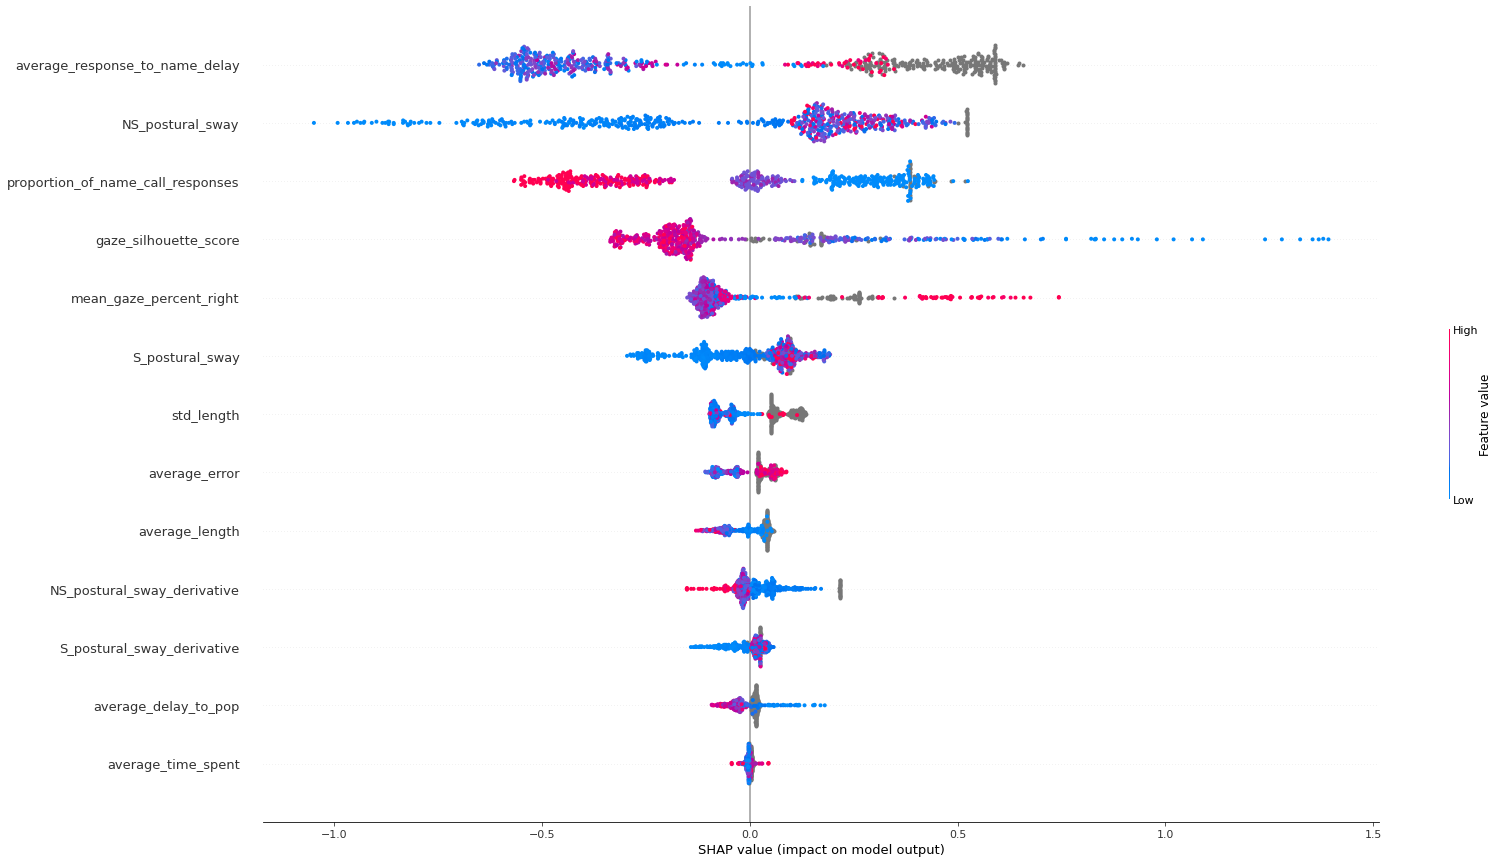

In [129]:
DEFAULT_PREDICTORS = [# GAZE RELATED
                   # 'diagnosis',
                     'mean_gaze_percent_right', #aggregated
                     'gaze_silhouette_score', #aggregated

                    # NAME CALL RELATED
                     'proportion_of_name_call_responses',
                     'average_response_to_name_delay',
                   #   'name_call_response_binary',


                    # POSTURAL SWAY RELATED
                     'S_postural_sway',  #aggregated
                     'NS_postural_sway',  #aggregated
                     'S_postural_sway_derivative',
                     'NS_postural_sway_derivative',

                    # TOUCH RELATED
                     'average_length',
                     'std_length',
                     'average_error',
                     #'pop_rate',
                     'average_delay_to_pop',
                     'average_time_spent']

df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='remote',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)

data.filter(administration={'studies': ['ARC', 'P1', 'P2', 'P3', 'P1R', 'P3R', 'IMPACT', 'SenseToKnowStudy'],
                          # 'order': 'first', 
                             'completed': True}, 
                           demographics={'age':[17, 45]}, 
                           clinical={'diagnosis': [0]},
                            verbose=True)


X, y = data.df[DEFAULT_PREDICTORS], data.y_train


df =  pd.read_csv(AUTISM_DATA_PATH)
data_not_scaled = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='remote',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=False,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)

data_not_scaled.filter(administration={'studies': ['ARC', 'P1', 'P2', 'P3', 'P1R', 'P3R', 'IMPACT', 'SenseToKnowStudy'],
                        #                'order': 'first', 
                                        'completed': True}, 
                           demographics={'age':[17, 45]}, 
                          clinical={'diagnosis': [0]},
                            verbose=False)


X, y = data_not_scaled.df[DEFAULT_PREDICTORS], data.y_train
X_display, y_display = data_not_scaled.df[DEFAULT_PREDICTORS], data_not_scaled.y_train



exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  verbosity=0, 
                  
                  experiment_folder_name='paper_experiment_1_fs',
                  save_experiment=False)


exp.fit_predict(num_cv=5)
display(exp.performances_df)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  verbosity=0, 
                  
                  experiment_folder_name='paper_experiment_1_fs',
                  save_experiment=False)

exp.fit()

print("The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of being autistic for the trained XGBoost model. \
      This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. \
      The color allows us match how changes in the value of a feature effect the change in risk.")

import shap 
explainer = shap.TreeExplainer(exp.model, feature_names=DEFAULT_PREDICTORS)
shap_values = explainer.shap_values(exp.dataset.X_train, approximate=False)

## SHAP Summary Plo
shap.summary_plot(shap_values, exp.dataset.X_train, feature_names=DEFAULT_PREDICTORS, plot_size=(25, 15))

**WIthout the RTN features**

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.824,0.707,0.737,0.252,0.983,0.661,0.313,0.73,0.472,0.817,0.689,0.551,0.89,0.183,0.449,0.11


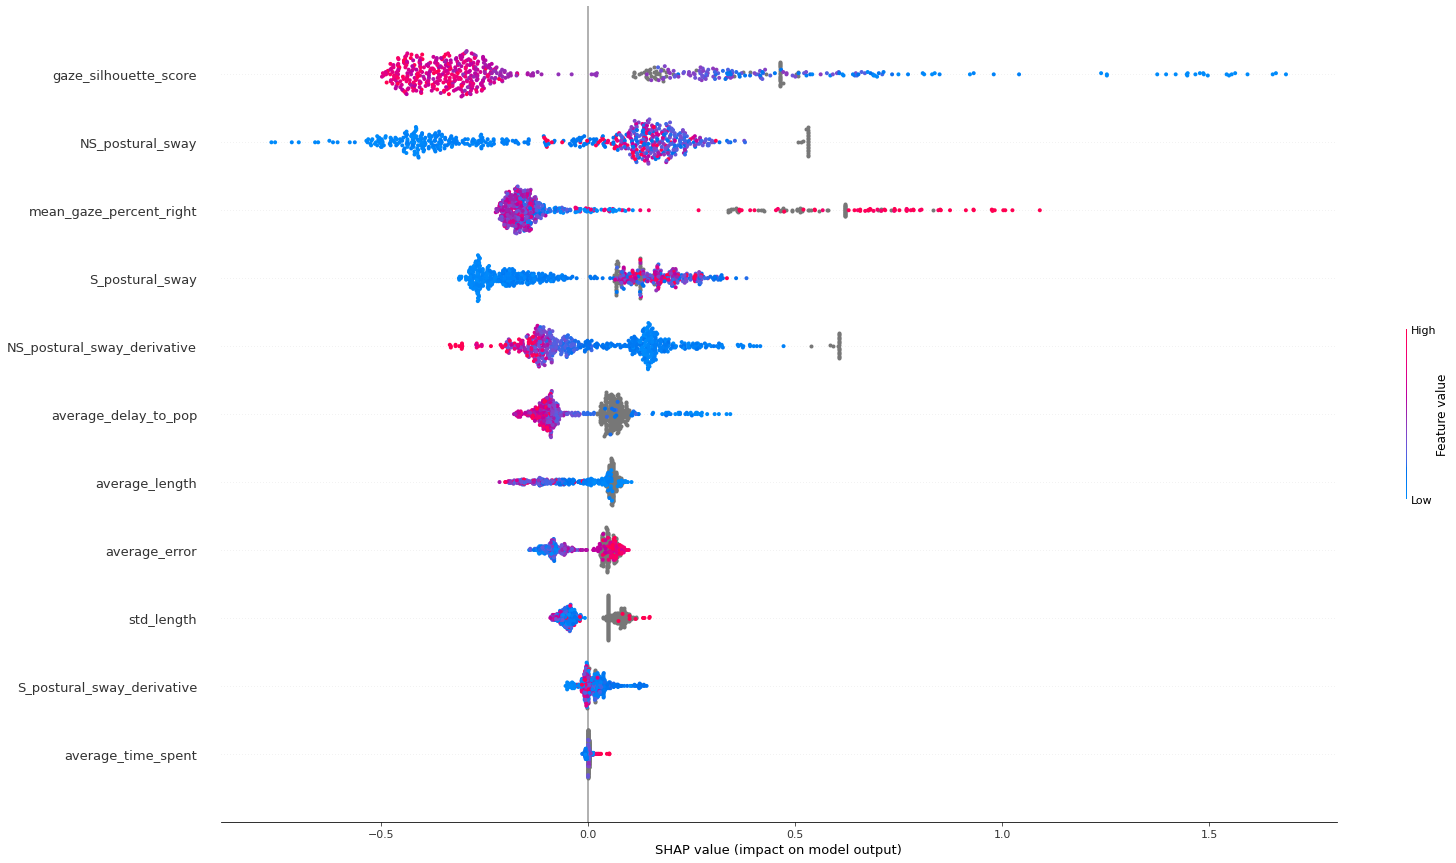

In [126]:
DEFAULT_PREDICTORS = [# GAZE RELATED
                   # 'diagnosis',
                     'mean_gaze_percent_right', #aggregated
                     'gaze_silhouette_score', #aggregated

                    # NAME CALL RELATED
                    # 'proportion_of_name_call_responses',
                    # 'average_response_to_name_delay',
                    #  'name_call_response_binary',


                    # POSTURAL SWAY RELATED
                     'S_postural_sway',  #aggregated
                     'NS_postural_sway',  #aggregated
                     'S_postural_sway_derivative',
                     'NS_postural_sway_derivative',

                    # TOUCH RELATED
                     'average_length',
                     'std_length',
                     'average_error',
                     #'pop_rate',
                     'average_delay_to_pop',
                     'average_time_spent']

df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='remote',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)

data.filter(administration={'studies': ['ARC', 'P1', 'P2', 'P3', 'P1R', 'P3R', 'IMPACT', 'SenseToKnowStudy'],
                          # 'order': 'first', 
                             'completed': True}, 
                           demographics={'age':[17, 45]}, 
                           clinical={'diagnosis': [0]},
                            verbose=True)


X, y = data.df[DEFAULT_PREDICTORS], data.y_train


df =  pd.read_csv(AUTISM_DATA_PATH)
data_not_scaled = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='remote',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=False,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)

data_not_scaled.filter(administration={'studies': ['ARC', 'P1', 'P2', 'P3', 'P1R', 'P3R', 'IMPACT', 'SenseToKnowStudy'],
                        #                'order': 'first', 
                                        'completed': True}, 
                           demographics={'age':[17, 45]}, 
                          clinical={'diagnosis': [0]},
                            verbose=False)


X, y = data_not_scaled.df[DEFAULT_PREDICTORS], data.y_train
X_display, y_display = data_not_scaled.df[DEFAULT_PREDICTORS], data_not_scaled.y_train



exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  verbosity=0, 
                  
                  experiment_folder_name='paper_experiment_1_fs',
                  save_experiment=False)


exp.fit_predict(num_cv=5)
display(exp.performances_df)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  verbosity=0, 
                  
                  experiment_folder_name='paper_experiment_1_fs',
                  save_experiment=False)

exp.fit()

## Explain the model's predictions on the entire dataset¶


import shap 
explainer = shap.TreeExplainer(exp.model, feature_names=DEFAULT_PREDICTORS)
shap_values = explainer.shap_values(exp.dataset.X_train, approximate=False)

## SHAP Summary Plo
shap.summary_plot(shap_values, exp.dataset.X_train, feature_names=DEFAULT_PREDICTORS, plot_size=(25, 15))

# Experiemnt: predicting whether the app is done remote or not based on our features - Only 17-45 mo neurotypical

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.766,0.38,0.752,0.19,0.96,0.39,0.235,0.747,0.282,0.617,0.766,0.276,0.932,0.383,0.724,0.068


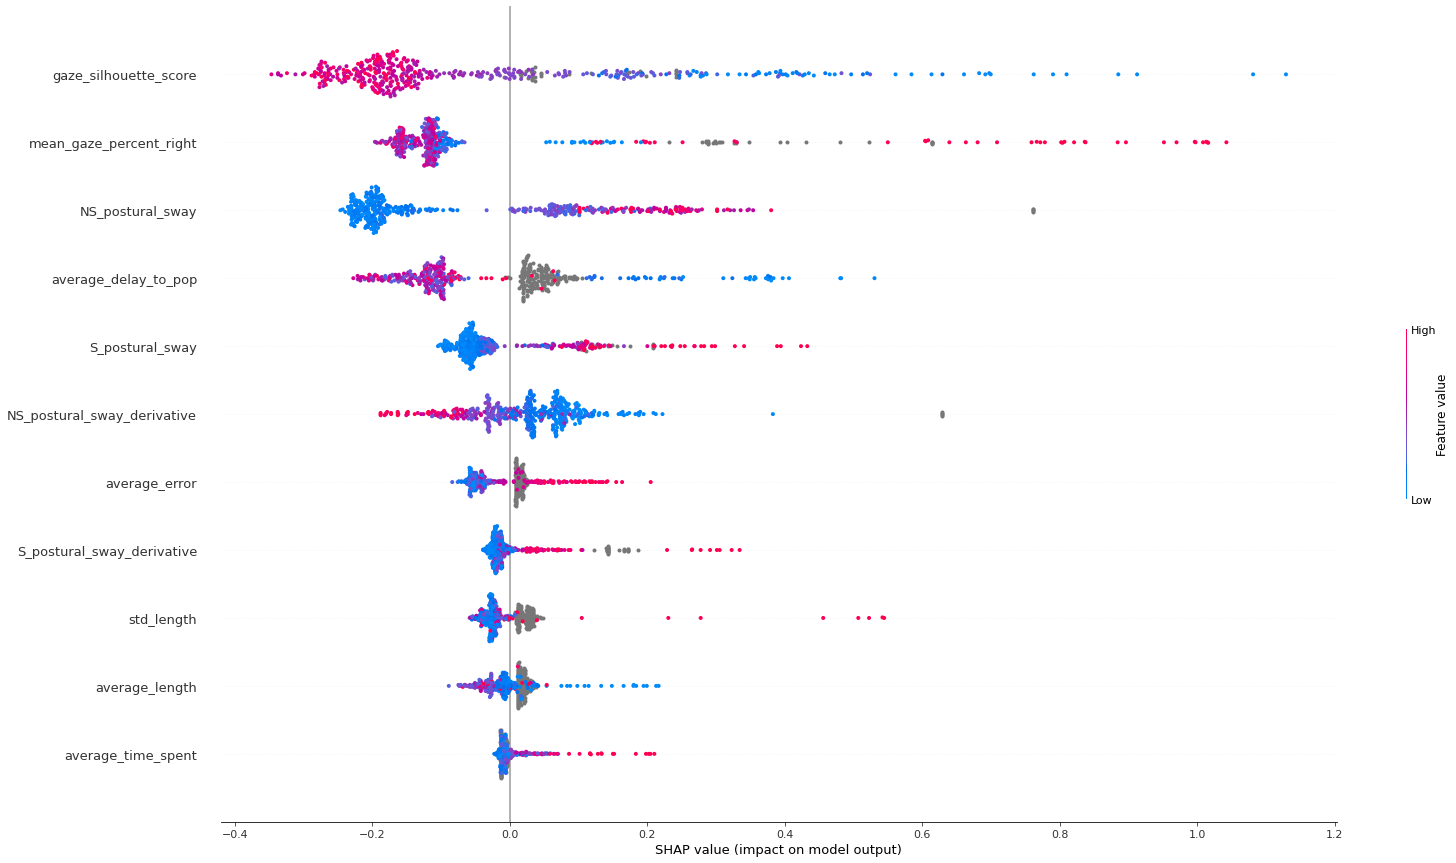

In [133]:
DEFAULT_PREDICTORS = [# GAZE RELATED
                   # 'diagnosis',
                     'mean_gaze_percent_right', #aggregated
                     'gaze_silhouette_score', #aggregated

                    # NAME CALL RELATED
                    # 'proportion_of_name_call_responses',
                    # 'average_response_to_name_delay',
                    #  'name_call_response_binary',


                    # POSTURAL SWAY RELATED
                     'S_postural_sway',  #aggregated
                     'NS_postural_sway',  #aggregated
                     'S_postural_sway_derivative',
                     'NS_postural_sway_derivative',

                    # TOUCH RELATED
                     'average_length',
                     'std_length',
                     'average_error',
                     #'pop_rate',
                     'average_delay_to_pop',
                     'average_time_spent']

df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='remote',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)

data.filter(administration={'studies': ['ARC', 'P1', 'SenseToKnowStudy'],
                           'order': 'first', 
                             'completed': True}, 
                           demographics={'age':[17, 45]}, 
                           clinical={'diagnosis': [0]},
                            verbose=False)


X, y = data.df[DEFAULT_PREDICTORS], data.y_train


df =  pd.read_csv(AUTISM_DATA_PATH)
data_not_scaled = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='remote',
                features_name = DEFAULT_PREDICTORS, 
                scale_data=False,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=None,#'papers',
               proportion_train=1)

data_not_scaled.filter(administration={'studies': ['ARC', 'P1', 'SenseToKnowStudy'],
                           'order': 'first', 
                             'completed': True}, 
                           demographics={'age':[17, 45]}, 
                           clinical={'diagnosis': [0, 1]},
                            verbose=True)


X, y = data_not_scaled.df[DEFAULT_PREDICTORS], data.y_train
X_display, y_display = data_not_scaled.df[DEFAULT_PREDICTORS], data_not_scaled.y_train



exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  verbosity=0, 
                  
                  experiment_folder_name='paper_experiment_1_fs',
                  save_experiment=False)


exp.fit_predict(num_cv=5)
display(exp.performances_df)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  verbosity=0, 
                  
                  experiment_folder_name='paper_experiment_1_fs',
                  save_experiment=False)

exp.fit()

## Explain the model's predictions on the entire dataset¶


import shap 
explainer = shap.TreeExplainer(exp.model, feature_names=DEFAULT_PREDICTORS)
shap_values = explainer.shap_values(exp.dataset.X_train, approximate=False)

## SHAP Summary Plo
shap.summary_plot(shap_values, exp.dataset.X_train, feature_names=DEFAULT_PREDICTORS, plot_size=(25, 15))


In [3]:
n=0
df =  pd.read_csv(AUTISM_DATA_PATH)

scenario='papers'

with open(os.path.join(DATA_DIR, 'selected_features_{}.pkl'.format(scenario)), 'rb') as f:
    features = pickle.load(f)
    
use_missing_indicator_variables = {'FunAtThePark':['FP_postural_sway', 'FP_postural_sway_derivative'],
                                           'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']}

for i, n_features in enumerate(list(features['xgboost'].keys())):
    for j, scenario in enumerate(['papers']):

        for approach in ["LogisticRegression", "DecisionTree",  "ebm", 'xgboost', "nam"]:

            df =  pd.read_csv(AUTISM_DATA_PATH)


            data = Dataset(df=df, 
                           missing_data_handling='encoding',
                           imputation_method='without',
                           sampling_method='without',
                           scenario = scenario, 
                           features_name = features[approach][n_features] if approach in features.keys() else features['ebm'][n_features],
                           scale_data=True, 
                           use_missing_indicator_variables=use_missing_indicator_variables,
                           verbosity=1, 
                           proportion_train=1)

            exp = Experiments(data.dataset_name,
                              dataset=data, 
                              approach=approach, 
                              previous_experiment=None,        
                              debug=True, 
                              verbosity=0, 
                              experiment_folder_name='paper_experiment_1_fs_custom_missing',
                              save_experiment=True)
            print("approach: {} - use_missing_indicator_variables: {} - n_features: {}".format(approach, use_missing_indicator_variables, n_features))
            exp.fit_predict(num_cv=16)
            display(exp.performances_df)


approach: LogisticRegression - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 10


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.732,0.266,0.811,0.083,0.845,0.356,0.178,0.832,0.266,0.465,0.87,0.27,0.94,0.535,0.73,0.06


approach: DecisionTree - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 10


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.659,0.372,0.878,0.202,0.964,0.406,0.319,0.915,0.359,0.256,0.983,0.611,0.927,0.744,0.389,0.073


approach: ebm - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 10


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.875,0.48,0.92,0.258,0.982,0.515,0.289,0.895,0.445,0.558,0.93,0.453,0.953,0.442,0.547,0.047


approach: xgboost - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 10


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.827,0.458,0.924,0.25,0.983,0.478,0.323,0.893,0.403,0.488,0.935,0.438,0.946,0.512,0.562,0.054


approach: nam - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 10


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),Area Under the Curve (AUC)
0,0.8522,0.4019,0.8875,0.1557,0.8593,0.483,0.278,0.8945,0.4129,0.4907,0.9364,0.4572,0.9469,0.5093,0.5428,0.0531,0.8522


approach: LogisticRegression - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 22


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.803,0.422,0.895,0.202,0.971,0.494,0.312,0.913,0.432,0.419,0.964,0.545,0.941,0.581,0.455,0.059


approach: DecisionTree - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 22


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.609,0.322,0.835,0.171,0.953,0.345,0.289,0.917,0.351,0.209,0.99,0.692,0.924,0.791,0.308,0.076


approach: ebm - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 22


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.861,0.42,0.89,0.2,0.973,0.442,0.235,0.893,0.365,0.419,0.942,0.429,0.94,0.581,0.571,0.06


approach: xgboost - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 22


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.854,0.49,0.939,0.272,0.986,0.485,0.327,0.887,0.411,0.535,0.923,0.418,0.95,0.465,0.582,0.05


approach: nam - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 22


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),Area Under the Curve (AUC)
0,0.8499,0.3759,0.883,0.1458,0.8787,0.4117,0.2352,0.8529,0.3334,0.514,0.888,0.3331,0.9469,0.486,0.6669,0.0531,0.8499


approach: LogisticRegression - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 32


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.78,0.381,0.88,0.15,0.825,0.472,0.289,0.895,0.397,0.465,0.94,0.444,0.944,0.535,0.556,0.056


approach: DecisionTree - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 32


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.613,0.298,0.799,0.168,0.946,0.34,0.319,0.906,NaN,0.0,1.0,NaN,0.906,1.0,NaN,0.094


approach: ebm - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 32


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.856,0.418,0.896,0.18,0.964,0.458,0.238,0.828,0.41,0.744,0.837,0.32,0.969,0.256,0.68,0.031


approach: xgboost - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 32


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.852,0.472,0.932,0.245,0.982,0.481,0.351,0.88,0.408,0.558,0.913,0.4,0.952,0.442,0.6,0.048


approach: nam - use_missing_indicator_variables: {'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative'], 'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative']} - n_features: 32


,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),Area Under the Curve (AUC)
0,0.841,0.3839,0.8834,0.1597,0.9374,0.418,0.2377,0.8631,0.3482,0.4907,0.9016,0.3765,0.9458,0.5093,0.6235,0.0542,0.841


In [45]:
df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = CVA_COLUMNS, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=4,
               scenario=None,
               proportion_train=1)

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Predicting diagnosis based on 58 features
Splitting dataset into test and train set.


In [46]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import shap
import pickle

def custom_spearmanr(x, y):
    from scipy.stats import spearmanr
    return spearmanr(x, y, nan_policy='omit').correlation

In [63]:
features = CVA_COLUMNS
features = [f for f in features if f not in ['PB_postural_sway', 'PB_postural_sway_derivative']]
scenario = 'papers'
features_importance = pd.DataFrame(columns=features)

# XGBOOST feature importance

In [64]:
approach = 'xgboost'

In [65]:
df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = features, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=4,
               scenario=scenario,
               proportion_train=1)

exp = Experiments(data.dataset_name,
              dataset=data, 
                approach=approach, 
                previous_experiment=None,        
                verbosity=4, 
                debug=True, 
                save_experiment=False)

exp.fit_vanilla()


for i, importance_type in enumerate(['weight', 'gain', 'cover']):

    scenario_feature_importance = pd.DataFrame(exp.model.get_booster().get_score(importance_type=importance_type, fmap=''), index=['xgboost - {}'.format(importance_type)])
    features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())

    
# Permutation test 
#result = permutation_importance(exp.model, exp.dataset.X_train,  exp.dataset.y_train, scoring=corrected_f1_sklearn, n_repeats=10, random_state=42, n_jobs=4)
#scenario_feature_importance = pd.DataFrame((result.importances_mean)[np.newaxis, :], columns=features, index=['Permutation - XGBoost'])
#features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())

# Shap values
#explainer = shap.TreeExplainer(exp.model)
#shap_values = explainer.shap_values(exp.dataset.X_train)
#scenario_feature_importance = pd.DataFrame((np.abs(shap_values).sum(axis=0))[np.newaxis, :], columns=features, index=['SHAP - XGBoost'])
#features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())


Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 2326/2823 keeping only subject in studies: ['ARC', 'P1'].
Removing 12/497 keeping first admin.
Removing 26/485 keeping only subject with diagnosis: [0, 1].
459 administrations left.


,id
diagnosis,
0.0,416
1.0,43


Splitting dataset into test and train set.
Predicting diagnosis based on 56 features
Splitting dataset into test and train set.


In [66]:
features_importance

,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,name_call_response_binary,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,BB_postural_sway,BB_postural_sway_derivative,RT_postural_sway,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage
xgboost - weight,0.255556,0.077778,0.233333,0.044444,0.100000,0.233333,0.044444,1.000000,0.077778,0.100000,0.555556,0.033333,0.344444,0.133333,0.011111,NaN,0.044444,0.111111,0.166667,0.011111,0.033333,0.033333,0.022222,0.044444,0.533333,0.200000,0.700000,0.166667,0.144444,0.111111,0.055556,0.066667,0.088889,0.011111,0.044444,0.022222,0.100000,0.011111,0.022222,0.055556,0.055556,0.044444,0.011111,0.022222,NaN,0.100000,0.077778,0.044444,NaN,0.011111,0.011111,NaN,0.022222,0.033333,NaN,0.044444
xgboost - gain,0.377016,0.211544,0.198359,0.321192,0.159935,0.157433,0.189496,0.460048,0.291193,0.361120,0.254525,0.442832,0.402814,0.328184,0.002342,NaN,0.349322,0.257190,0.264746,0.152409,0.149345,0.182140,0.161133,0.257823,0.562102,0.302557,0.826735,0.558751,0.233317,0.281374,0.317484,0.428276,0.788789,0.107184,1.000000,0.504053,0.214853,0.376464,0.208506,0.177503,0.316980,0.140633,0.046850,0.135276,NaN,0.421716,0.241228,0.209423,NaN,0.502903,0.015679,NaN,0.351530,0.142995,NaN,0.235652
xgboost - cover,0.171438,0.467696,0.648636,0.076620,0.245091,0.669254,0.600657,0.347267,0.185868,0.089737,0.556818,0.290646,0.336775,0.131960,0.032263,NaN,0.110348,0.100572,0.807556,0.994705,0.055811,0.073627,0.038342,0.187681,0.858047,0.547707,0.845988,0.514683,0.330722,0.628285,0.395207,0.140087,0.854034,0.822186,1.000000,0.160591,0.503656,0.051219,0.050978,0.259541,0.063058,0.718848,0.036596,0.042560,NaN,0.072459,0.047521,0.047890,NaN,0.064919,0.034930,NaN,0.038455,0.044048,NaN,0.235911


# Explanable Boosting Machine feature importance

In [67]:
approach = 'ebm'

In [68]:
df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = features, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=4,
               scenario=scenario,
               proportion_train=1)

exp = Experiments(data.dataset_name,
              dataset=data, 
                approach=approach, 
                previous_experiment=None,        
                verbosity=4, 
                debug=True, 
                save_experiment=False)

exp.fit_vanilla()

ebm_global = exp.model.explain_global()
scenario_feature_importance = pd.DataFrame(np.array(ebm_global._internal_obj['overall']['scores'])[np.newaxis, :], columns=ebm_global.feature_names, index=['EBM'])
features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 2326/2823 keeping only subject in studies: ['ARC', 'P1'].
Removing 12/497 keeping first admin.
Removing 26/485 keeping only subject with diagnosis: [0, 1].
459 administrations left.


,id
diagnosis,
0.0,416
1.0,43


Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Predicting diagnosis based on 56 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.


In [69]:
features_importance

,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,name_call_response_binary,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,BB_postural_sway,BB_postural_sway_derivative,RT_postural_sway,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage,mean_gaze_percent_right x MML_postural_sway,mean_gaze_percent_right x MML_postural_sway_derivative,mean_gaze_percent_right x RT_postural_sway,NS_postural_sway x NS_postural_sway_derivative,mean_gaze_percent_right x RT_postural_sway_derivative,BB_gaze_percent_right x MML_postural_sway,DIGRRL_postural_sway_derivative x MML_postural_sway,MP_postural_sway_derivative x MML_postural_sway,FB_postural_sway x MML_postural_sway,mean_gaze_percent_right x BB_postural_sway
xgboost - weight,0.255556,0.077778,0.233333,0.044444,0.100000,0.233333,0.044444,1.000000,0.077778,0.100000,0.555556,0.033333,0.344444,0.133333,0.011111,NaN,0.044444,0.111111,0.166667,0.011111,0.033333,0.033333,0.022222,0.044444,0.533333,0.200000,0.700000,0.166667,0.144444,0.111111,0.055556,0.066667,0.088889,0.011111,0.044444,0.022222,0.100000,0.011111,0.022222,0.055556,0.055556,0.044444,0.011111,0.022222,NaN,0.100000,0.077778,0.044444,NaN,0.011111,0.011111,NaN,0.022222,0.033333,NaN,0.044444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xgboost - gain,0.377016,0.211544,0.198359,0.321192,0.159935,0.157433,0.189496,0.460048,0.291193,0.361120,0.254525,0.442832,0.402814,0.328184,0.002342,NaN,0.349322,0.257190,0.264746,0.152409,0.149345,0.182140,0.161133,0.257823,0.562102,0.302557,0.826735,0.558751,0.233317,0.281374,0.317484,0.428276,0.788789,0.107184,1.000000,0.504053,0.214853,0.376464,0.208506,0.177503,0.316980,0.140633,0.046850,0.135276,NaN,0.421716,0.241228,0.209423,NaN,0.502903,0.015679,NaN,0.351530,0.142995,NaN,0.235652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xgboost - cover,0.171438,0.467696,0.648636,0.076620,0.245091,0.669254,0.600657,0.347267,0.185868,0.089737,0.556818,0.290646,0.336775,0.131960,0.032263,NaN,0.110348,0.100572,0.807556,0.994705,0.055811,0.073627,0.038342,0.187681,0.858047,0.547707,0.845988,0.514683,0.330722,0.628285,0.395207,0.140087,0.854034,0.822186,1.000000,0.160591,0.503656,0.051219,0.050978,0.259541,0.063058,0.718848,0.036596,0.042560,NaN,0.072459,0.047521,0.047890,NaN,0.064919,0.034930,NaN,0.038455,0.044048,NaN,0.235911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EBM,0.634517,0.612406,0.704196,0.711418,0.604251,0.361801,0.570284,0.848941,0.687937,0.660477,0.662578,0.666569,0.275712,0.210216,0.221592,0.238584,0.168105,0.260499,0.251197,0.150601,0.133591,0.123356,0.787628,0.382007,0.550036,0.380166,0.772143,0.508702,0.587579,0.269981,0.345368,0.383870,0.731734,0.230839,0.600288,0.118506,0.168277,0.175660,0.154032,0.206469,0.449754,0.242936,0.216309,0.126174,0.198075,0.415378,0.328240,0.149109,0.105148,0.130738,0.195152,0.110922,0.215100,0.218293,0.118796,0.175588,0.423598,0.359981,0.701108,0.454295,1.0,0.486146,0.59454,0.506357,0.603742,0.686424


# LogisticRegression feature importance

In [70]:
approach = 'LogisticRegression'

In [71]:
df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = features, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=4,
               scenario=scenario,
               proportion_train=1)

exp = Experiments(data.dataset_name,
              dataset=data, 
                approach=approach, 
                previous_experiment=None,        
                verbosity=4, 
                debug=True, 
                save_experiment=False)

exp.fit_vanilla()


scenario_feature_importance = pd.DataFrame(np.abs(exp.model.coef_),columns=features, index=['LogisticRegression'])
features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())

    
# Permutation test 
#result = permutation_importance(exp.model, exp.dataset.X_train,  exp.dataset.y_train, scoring=corrected_f1_sklearn, n_repeats=10, random_state=42, n_jobs=4)
#scenario_feature_importance = pd.DataFrame((result.importances_mean)[np.newaxis, :], columns=features, index=['Permutation - LosisticRegression'])
#features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 2326/2823 keeping only subject in studies: ['ARC', 'P1'].
Removing 12/497 keeping first admin.
Removing 26/485 keeping only subject with diagnosis: [0, 1].
459 administrations left.


,id
diagnosis,
0.0,416
1.0,43


Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Predicting diagnosis based on 56 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.


# DecisionTree feature importance

In [72]:
approach = 'DecisionTree'

In [73]:
df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = features, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=4,
               scenario=scenario,
               proportion_train=1)

exp = Experiments(data.dataset_name,
              dataset=data, 
                approach=approach, 
                previous_experiment=None,        
                verbosity=4, 
                debug=True, 
                save_experiment=False)

exp.fit_vanilla()


scenario_feature_importance = pd.DataFrame(np.abs(np.array(exp.model.feature_importances_))[np.newaxis, :], columns=features, index=['DecisionTree'])
features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())





Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 2326/2823 keeping only subject in studies: ['ARC', 'P1'].
Removing 12/497 keeping first admin.
Removing 26/485 keeping only subject with diagnosis: [0, 1].
459 administrations left.


,id
diagnosis,
0.0,416
1.0,43


Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Predicting diagnosis based on 56 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.


# ANOVA ranking of the features

In [74]:
from sklearn.feature_selection import f_classif

scores = np.zeros(len(features))
ps = np.zeros(len(features))

for idx_feat, feat in enumerate(range(len(features))):
    
    X = deepcopy(data.X_train[:,feat])
    y = deepcopy(data.y_train)
    
    y = y[~np.isnan(X)]
    X = X[~np.isnan(X)][:, np.newaxis]
    if X.shape[0]==0:
        scores[idx_feat], ps[idx_feat] = 0, 0
        continue
        
    scores[idx_feat], p = f_classif(X, y)
    
    ps[idx_feat] = np.abs(np.log10(p))
        
        
    
scenario_feature_importance = pd.DataFrame(ps[np.newaxis, :], columns=features, index=['ANOVA'])
features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())
features_importance
    

,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,name_call_response_binary,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,BB_postural_sway,BB_postural_sway_derivative,RT_postural_sway,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage,mean_gaze_percent_right x MML_postural_sway,mean_gaze_percent_right x MML_postural_sway_derivative,mean_gaze_percent_right x RT_postural_sway,NS_postural_sway x NS_postural_sway_derivative,mean_gaze_percent_right x RT_postural_sway_derivative,BB_gaze_percent_right x MML_postural_sway,DIGRRL_postural_sway_derivative x MML_postural_sway,MP_postural_sway_derivative x MML_postural_sway,FB_postural_sway x MML_postural_sway,mean_gaze_percent_right x BB_postural_sway
xgboost - weight,0.255556,0.077778,0.233333,0.044444,0.100000,0.233333,0.044444,1.000000,0.077778,0.100000,0.555556,0.033333,0.344444,0.133333,0.011111,NaN,0.044444,0.111111,0.166667,0.011111,0.033333,0.033333,0.022222,0.044444,0.533333,0.200000,0.700000,0.166667,0.144444,0.111111,0.055556,0.066667,0.088889,0.011111,0.044444,0.022222,0.100000,0.011111,0.022222,0.055556,0.055556,0.044444,0.011111,0.022222,NaN,0.100000,0.077778,0.044444,NaN,0.011111,0.011111,NaN,0.022222,0.033333,NaN,0.044444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xgboost - gain,0.377016,0.211544,0.198359,0.321192,0.159935,0.157433,0.189496,0.460048,0.291193,0.361120,0.254525,0.442832,0.402814,0.328184,0.002342,NaN,0.349322,0.257190,0.264746,0.152409,0.149345,0.182140,0.161133,0.257823,0.562102,0.302557,0.826735,0.558751,0.233317,0.281374,0.317484,0.428276,0.788789,0.107184,1.000000,0.504053,0.214853,0.376464,0.208506,0.177503,0.316980,0.140633,0.046850,0.135276,NaN,0.421716,0.241228,0.209423,NaN,0.502903,0.015679,NaN,0.351530,0.142995,NaN,0.235652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xgboost - cover,0.171438,0.467696,0.648636,0.076620,0.245091,0.669254,0.600657,0.347267,0.185868,0.089737,0.556818,0.290646,0.336775,0.131960,0.032263,NaN,0.110348,0.100572,0.807556,0.994705,0.055811,0.073627,0.038342,0.187681,0.858047,0.547707,0.845988,0.514683,0.330722,0.628285,0.395207,0.140087,0.854034,0.822186,1.000000,0.160591,0.503656,0.051219,0.050978,0.259541,0.063058,0.718848,0.036596,0.042560,NaN,0.072459,0.047521,0.047890,NaN,0.064919,0.034930,NaN,0.038455,0.044048,NaN,0.235911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EBM,0.634517,0.612406,0.704196,0.711418,0.604251,0.361801,0.570284,0.848941,0.687937,0.660477,0.662578,0.666569,0.275712,0.210216,0.221592,0.238584,0.168105,0.260499,0.251197,0.150601,0.133591,0.123356,0.787628,0.382007,0.550036,0.380166,0.772143,0.508702,0.587579,0.269981,0.345368,0.383870,0.731734,0.230839,0.600288,0.118506,0.168277,0.175660,0.154032,0.206469,0.449754,0.242936,0.216309,0.126174,0.198075,0.415378,0.328240,0.149109,0.105148,0.130738,0.195152,0.110922,0.215100,0.218293,0.118796,0.175588,0.423598,0.359981,0.701108,0.454295,1.0,0.486146,0.59454,0.506357,0.603742,0.686424
LogisticRegression,0.199639,0.273885,0.302083,0.032051,0.053038,0.052703,0.330133,0.348868,0.006690,0.551554

# Mann-Whitney-U ranking of the features

In [75]:
from scipy.stats import mannwhitneyu

scores = np.zeros(len(features))
ps = np.zeros(len(features))

for idx_feat, feat in enumerate(range(len(features))):
    
    X = deepcopy(data.X_train[:,feat])
    y = deepcopy(data.y_train)
    
    y = y[~np.isnan(X)]
    X = X[~np.isnan(X)][:, np.newaxis]
    if X.shape[0]==0:
        scores[idx_feat], ps[idx_feat] = 0, 0
        continue
        
    scores[idx_feat], p = mannwhitneyu(X, y)
    
    ps[idx_feat] = np.abs(np.log10(p))
        
        
    
scenario_feature_importance = pd.DataFrame(ps[np.newaxis, :], columns=features, index=['MWU'])
features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())
features_importance
    

,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,name_call_response_binary,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,BB_postural_sway,BB_postural_sway_derivative,RT_postural_sway,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage,mean_gaze_percent_right x MML_postural_sway,mean_gaze_percent_right x MML_postural_sway_derivative,mean_gaze_percent_right x RT_postural_sway,NS_postural_sway x NS_postural_sway_derivative,mean_gaze_percent_right x RT_postural_sway_derivative,BB_gaze_percent_right x MML_postural_sway,DIGRRL_postural_sway_derivative x MML_postural_sway,MP_postural_sway_derivative x MML_postural_sway,FB_postural_sway x MML_postural_sway,mean_gaze_percent_right x BB_postural_sway
xgboost - weight,0.255556,0.077778,0.233333,0.044444,0.100000,0.233333,0.044444,1.000000,0.077778,0.100000,0.555556,0.033333,0.344444,0.133333,0.011111,NaN,0.044444,0.111111,0.166667,0.011111,0.033333,0.033333,0.022222,0.044444,0.533333,0.200000,0.700000,0.166667,0.144444,0.111111,0.055556,0.066667,0.088889,0.011111,0.044444,0.022222,0.100000,0.011111,0.022222,0.055556,0.055556,0.044444,0.011111,0.022222,NaN,0.100000,0.077778,0.044444,NaN,0.011111,0.011111,NaN,0.022222,0.033333,NaN,0.044444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xgboost - gain,0.377016,0.211544,0.198359,0.321192,0.159935,0.157433,0.189496,0.460048,0.291193,0.361120,0.254525,0.442832,0.402814,0.328184,0.002342,NaN,0.349322,0.257190,0.264746,0.152409,0.149345,0.182140,0.161133,0.257823,0.562102,0.302557,0.826735,0.558751,0.233317,0.281374,0.317484,0.428276,0.788789,0.107184,1.000000,0.504053,0.214853,0.376464,0.208506,0.177503,0.316980,0.140633,0.046850,0.135276,NaN,0.421716,0.241228,0.209423,NaN,0.502903,0.015679,NaN,0.351530,0.142995,NaN,0.235652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xgboost - cover,0.171438,0.467696,0.648636,0.076620,0.245091,0.669254,0.600657,0.347267,0.185868,0.089737,0.556818,0.290646,0.336775,0.131960,0.032263,NaN,0.110348,0.100572,0.807556,0.994705,0.055811,0.073627,0.038342,0.187681,0.858047,0.547707,0.845988,0.514683,0.330722,0.628285,0.395207,0.140087,0.854034,0.822186,1.000000,0.160591,0.503656,0.051219,0.050978,0.259541,0.063058,0.718848,0.036596,0.042560,NaN,0.072459,0.047521,0.047890,NaN,0.064919,0.034930,NaN,0.038455,0.044048,NaN,0.235911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EBM,0.634517,0.612406,0.704196,0.711418,0.604251,0.361801,0.570284,0.848941,0.687937,0.660477,0.662578,0.666569,0.275712,0.210216,0.221592,0.238584,0.168105,0.260499,0.251197,0.150601,0.133591,0.123356,0.787628,0.382007,0.550036,0.380166,0.772143,0.508702,0.587579,0.269981,0.345368,0.383870,0.731734,0.230839,0.600288,0.118506,0.168277,0.175660,0.154032,0.206469,0.449754,0.242936,0.216309,0.126174,0.198075,0.415378,0.328240,0.149109,0.105148,0.130738,0.195152,0.110922,0.215100,0.218293,0.118796,0.175588,0.423598,0.359981,0.701108,0.454295,1.0,0.486146,0.59454,0.506357,0.603742,0.686424
LogisticRegression,0.199639,0.273885,0.302083,0.032051,0.053038,0.052703,0.330133,0.348868,0.006690,0.551554

# Visualzation

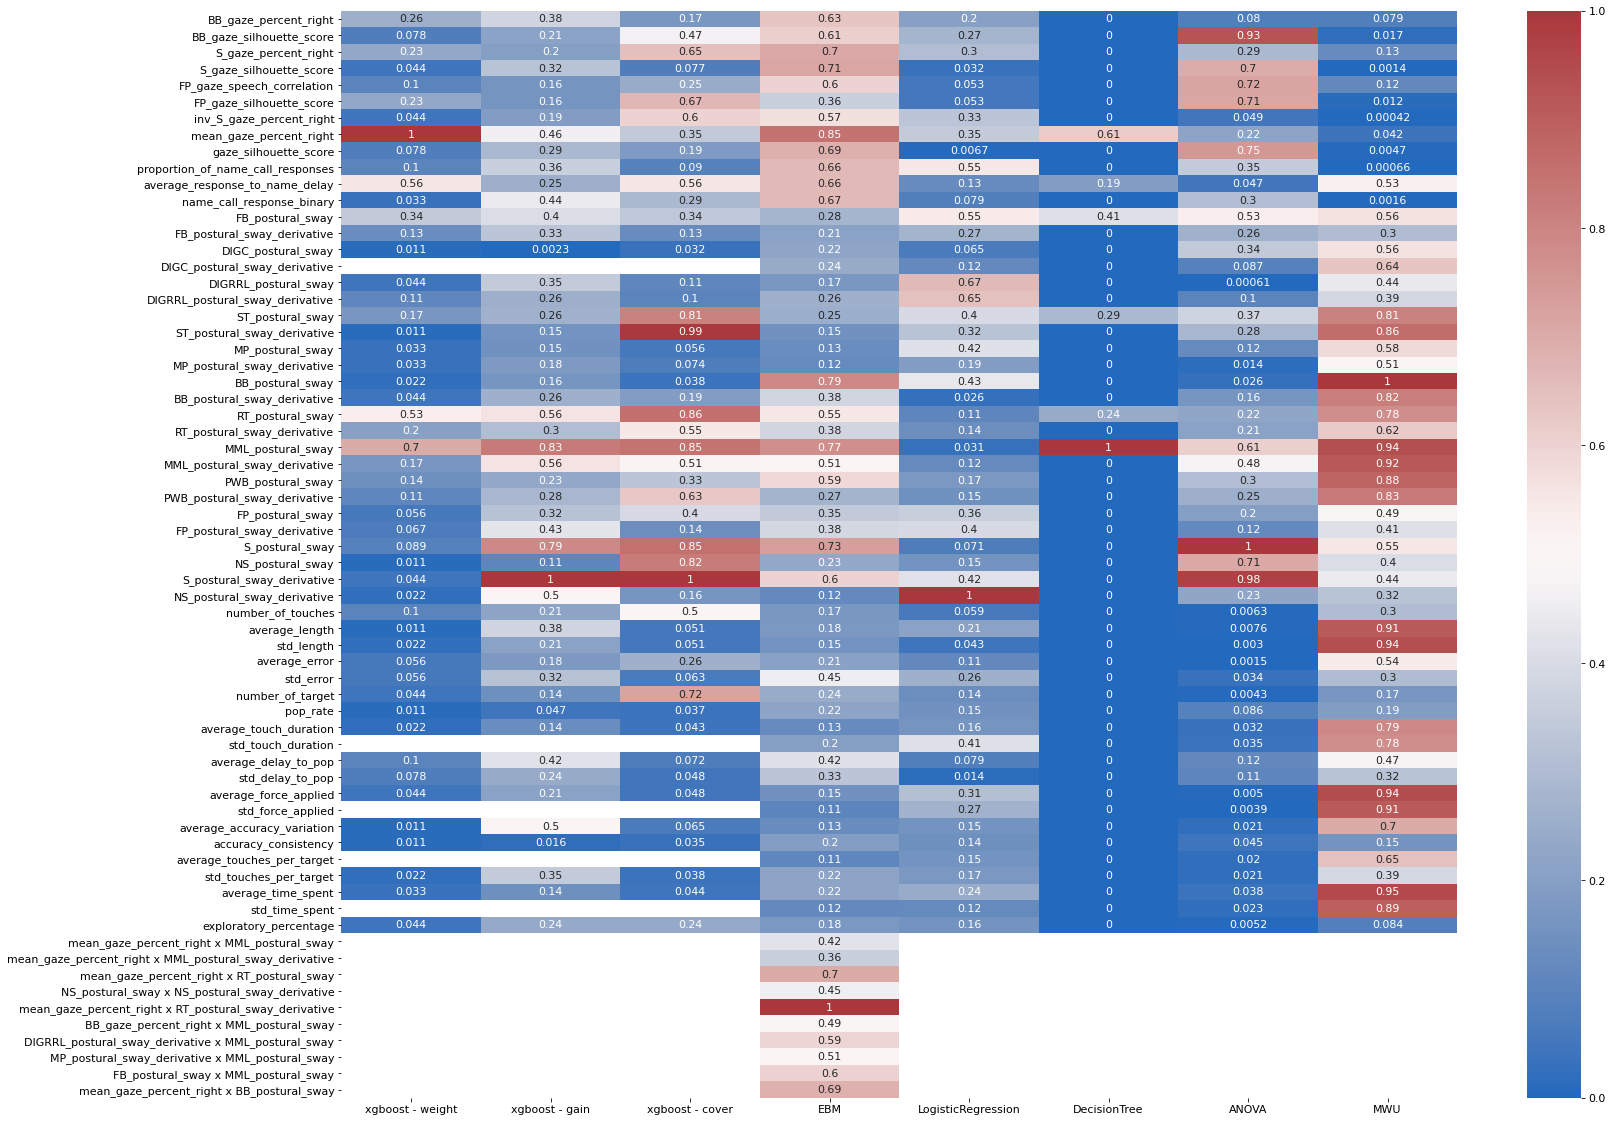

In [76]:
plt.figure(figsize=(25, 20))
sns.heatmap(features_importance.transpose(), annot=True, cmap="vlag")
plt.show()

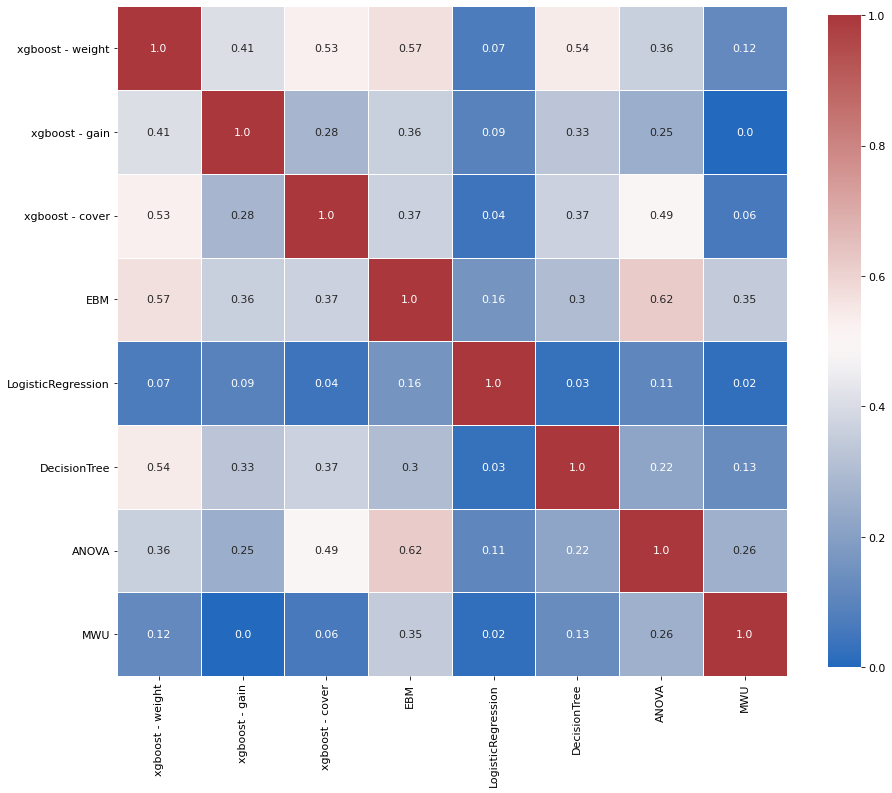

In [77]:
# Computes feature correlation
df_corr = features_importance.transpose().corr(method=custom_spearmanr)

plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(df_corr.round(2)), square=True,
            center=0.5,  annot=True, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

# Removing Correlated features first

In [ ]:
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

def custom_spearmanr(x, y):
    from scipy.stats import spearmanr
    return spearmanr(x, y, nan_policy='omit').correlation

In [79]:
df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = features, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=4,
               scenario=scenario,
               proportion_train=1)

X_train, X_test, y_train, y_test = train_test_split(exp.dataset.X_train, exp.dataset.y_train, test_size=.3, stratify=exp.dataset.y_train, random_state=42)

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 2326/2823 keeping only subject in studies: ['ARC', 'P1'].
Removing 12/497 keeping first admin.
Removing 26/485 keeping only subject with diagnosis: [0, 1].
459 administrations left.


,id
diagnosis,
0.0,416
1.0,43


Splitting dataset into test and train set.
Predicting diagnosis based on 56 features
Splitting dataset into test and train set.


## Features agglomerative hierarchical clustering

<AxesSubplot:>

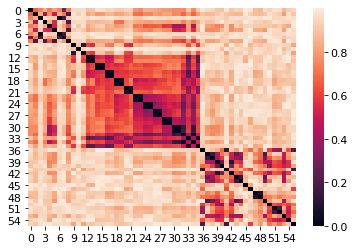

In [346]:
sns.heatmap(distance_matrix)

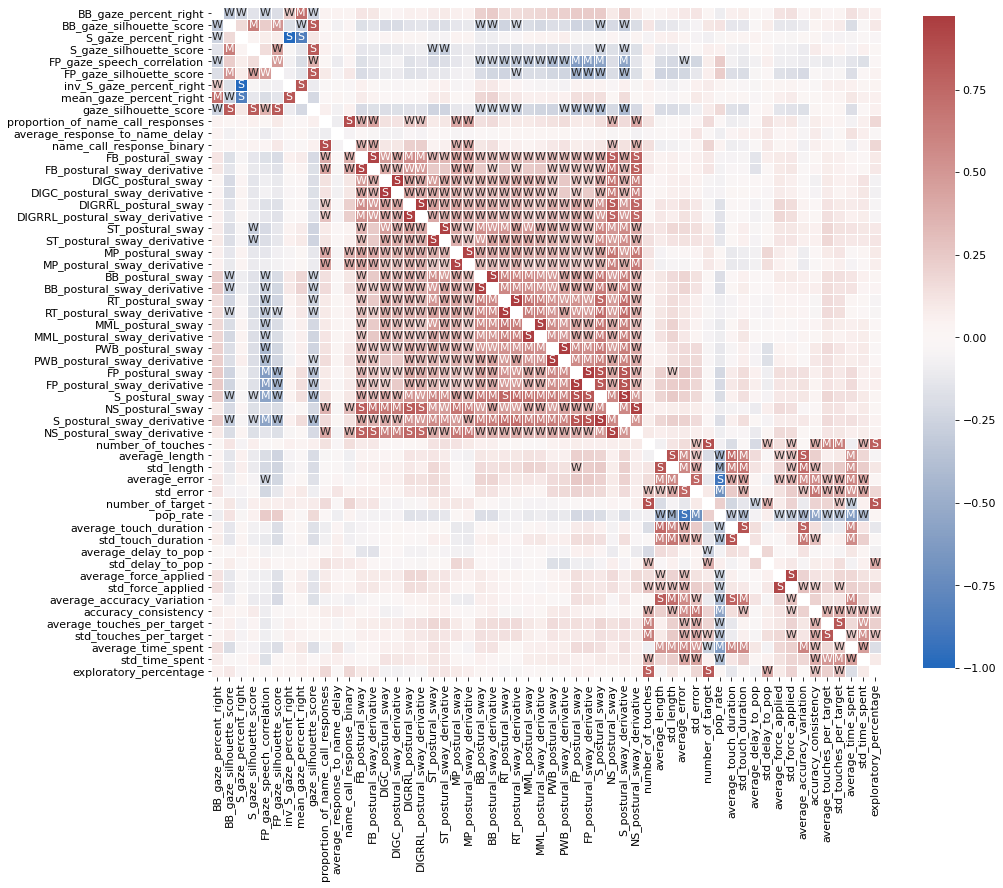

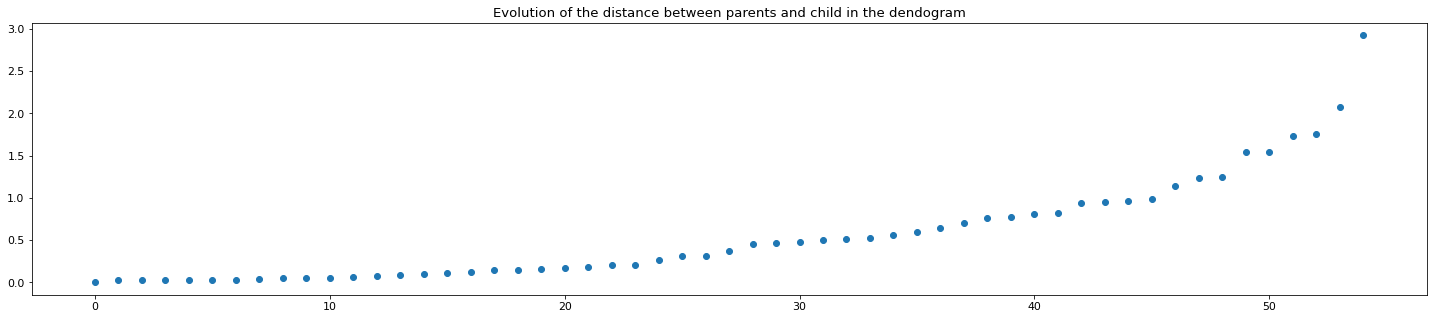

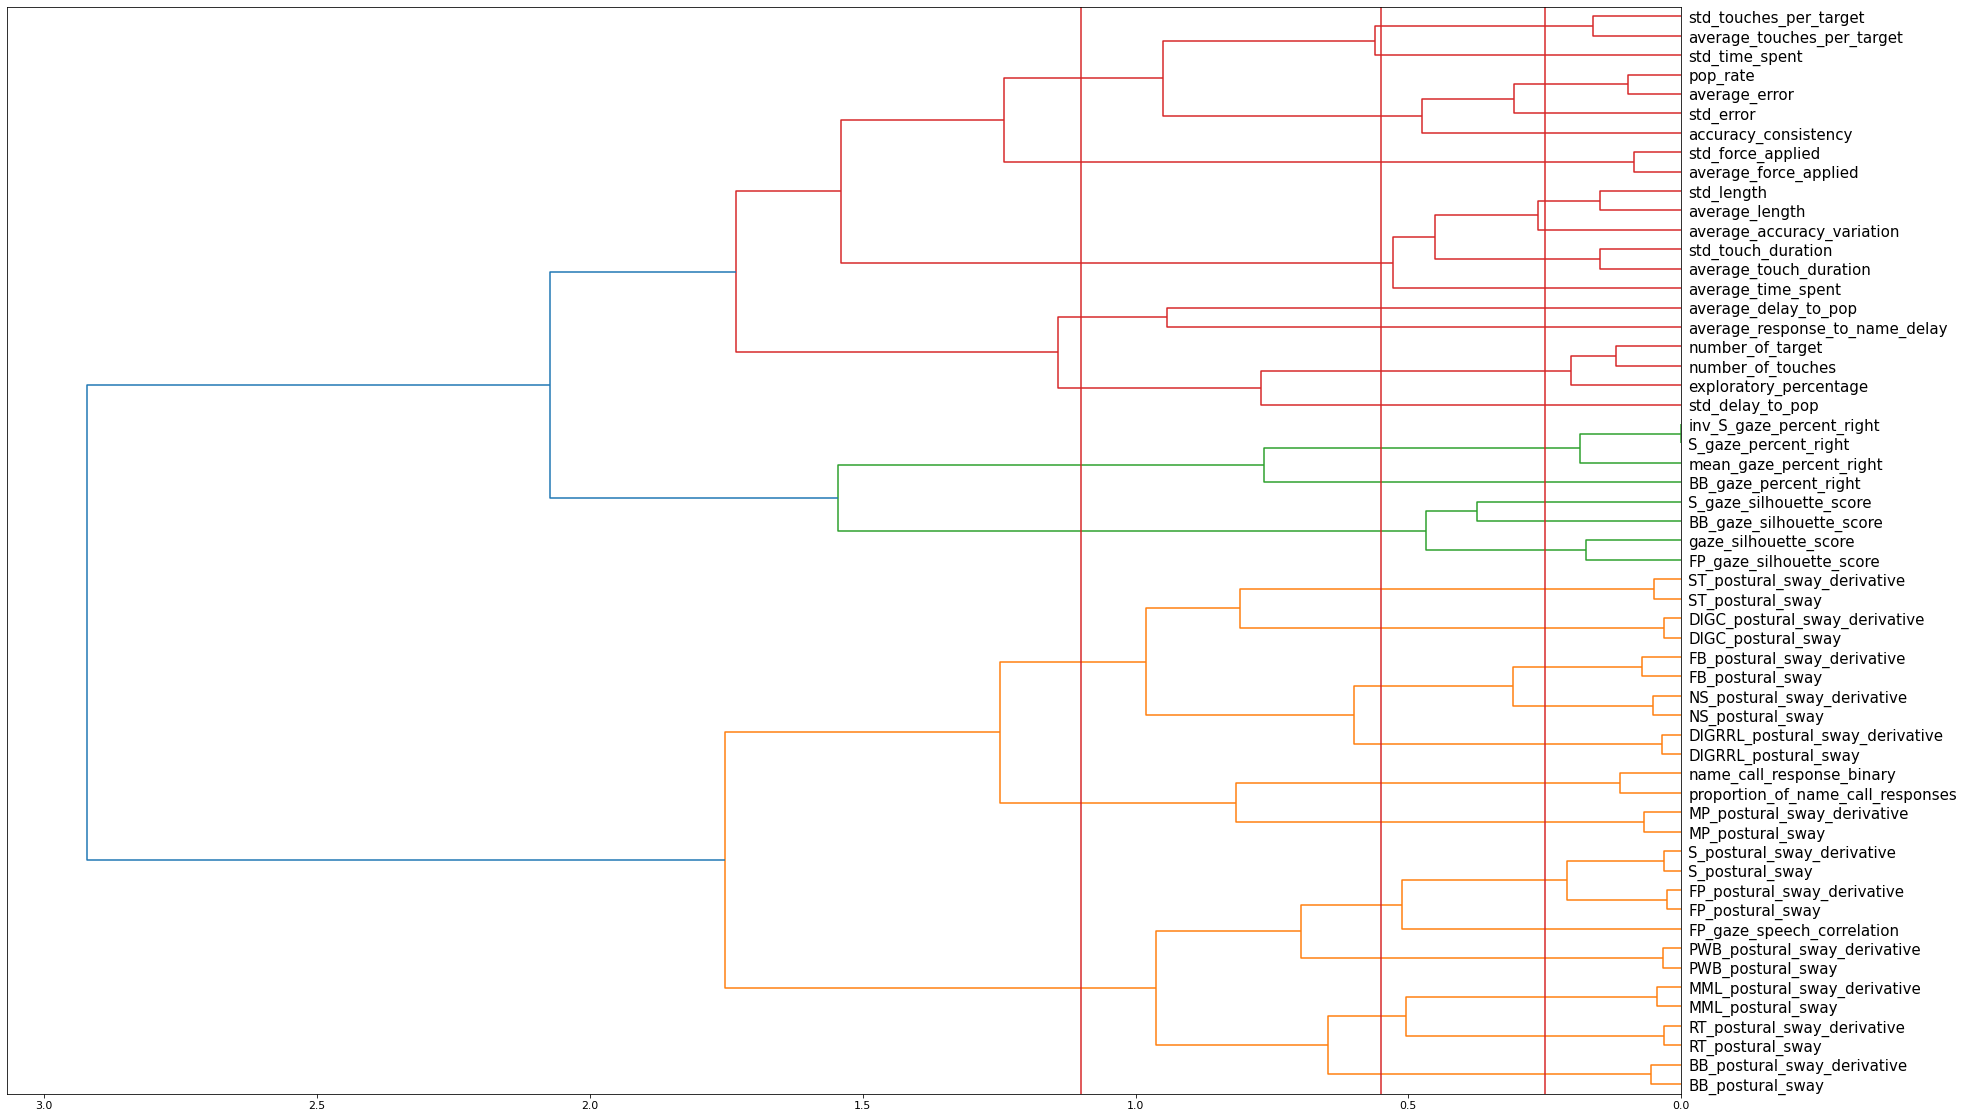

In [80]:
df_X = data.df[features]

# Computes feature correlation
df_corr = df_X.corr(method=custom_spearmanr)
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});
    
    
    
corr = spearmanr(data.X_train, nan_policy='omit').correlation
corr = np.nan_to_num(corr)

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)


dist_linkage = hierarchy.ward(squareform(distance_matrix))
fi(25, 5)
plt.scatter(np.arange(len(dist_linkage[:,2])), dist_linkage[:,2])
plt.title("Evolution of the distance between parents and child in the dendogram")

fig,ax1 = plt.subplots(1, 1, figsize=(30, 20))
dendro = hierarchy.dendrogram(dist_linkage, labels=features, ax=ax1, orientation='left', leaf_rotation=0, leaf_font_size=15)
thresholds = [1.1, 0.55, 0.25]
for th in thresholds:
    ax1.axvline(x=th, color='tab:red')




In [330]:
dendro['ivl']

['BB_postural_sway',
 'BB_postural_sway_derivative',
 'RT_postural_sway',
 'RT_postural_sway_derivative',
 'MML_postural_sway',
 'MML_postural_sway_derivative',
 'PWB_postural_sway',
 'PWB_postural_sway_derivative',
 'FP_gaze_speech_correlation',
 'FP_postural_sway',
 'FP_postural_sway_derivative',
 'S_postural_sway',
 'S_postural_sway_derivative',
 'MP_postural_sway',
 'MP_postural_sway_derivative',
 'proportion_of_name_call_responses',
 'name_call_response_binary',
 'DIGRRL_postural_sway',
 'DIGRRL_postural_sway_derivative',
 'NS_postural_sway',
 'NS_postural_sway_derivative',
 'FB_postural_sway',
 'FB_postural_sway_derivative',
 'DIGC_postural_sway',
 'DIGC_postural_sway_derivative',
 'ST_postural_sway',
 'ST_postural_sway_derivative',
 'FP_gaze_silhouette_score',
 'gaze_silhouette_score',
 'BB_gaze_silhouette_score',
 'S_gaze_silhouette_score',
 'BB_gaze_percent_right',
 'mean_gaze_percent_right',
 'S_gaze_percent_right',
 'inv_S_gaze_percent_right',
 'std_delay_to_pop',
 'explorat

## Re-do feature importance computation for each subset of features for each models

In [81]:
scenario_selected_features = {}

### XGBOOST

In [ ]:
approach = 'xgboost'
scenario_selected_features[approach] = {}


for th in thresholds:
    print("Threshold on the dendogram: {}".format(th))
    

    cluster_ids = hierarchy.fcluster(dist_linkage, th, criterion="distance")

    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
        
    n_features = len(cluster_id_to_feature_ids.keys())
    scenario_selected_features[approach][n_features] = []
    
    selected_features = []
    
    # For each cluster, select the best perfrming feature best on some criterium
    for value in cluster_id_to_feature_ids.values():
        
        clustered_features = np.array(features)[value]
        


        df =  pd.read_csv(AUTISM_DATA_PATH)
        data = Dataset(df=df, 
                       missing_data_handling='without', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='diagnosis',
                        features_name = list(clustered_features), 
                        scale_data=True,
                        use_missing_indicator_variables=False,
                       verbosity=0,
                       scenario=scenario,
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                      dataset=data, 
                        approach=approach, 
                        previous_experiment=None,        
                        verbosity=0, 
                        debug=True, 
                        save_experiment=False)

        exp.fit_vanilla()
        scenario_selected_features[approach][n_features].append(clustered_features[np.argmax(np.array(list(exp.model.get_booster().get_score(importance_type=importance_type, fmap='').values())))])
        
        scenario_feature_importance = pd.DataFrame(exp.model.get_booster().get_score(importance_type='gain', fmap=''), index=['xgboost - gain'])

        scenario_feature_importance /= scenario_feature_importance.max().max()
        #display(scenario_feature_importance.transpose().sort_values(by='xgboost - gain', ascending=False).transpose())



### EBM

In [ ]:
approach = 'ebm'
scenario_selected_features[approach] = {}


for th in thresholds:
    
    cluster_ids = hierarchy.fcluster(dist_linkage, th, criterion="distance")

    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
        
    n_features = len(cluster_id_to_feature_ids.keys())
    scenario_selected_features[approach][n_features] = []

    selected_features = []
    
    # For each cluster, select the best perfrming feature best on some criterium
    for value in cluster_id_to_feature_ids.values():
        
        clustered_features = np.array(features)[value]
        


        df =  pd.read_csv(AUTISM_DATA_PATH)
        data = Dataset(df=df, 
                       missing_data_handling='encoding', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='diagnosis',
                        features_name = list(clustered_features), 
                        scale_data=True,
                        use_missing_indicator_variables=False,
                       verbosity=0,
                       scenario=scenario,
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                      dataset=data, 
                        approach=approach, 
                        previous_experiment=None,        
                        verbosity=0, 
                        debug=True, 
                        save_experiment=False)

        exp.fit_vanilla()
        
        
        ebm_global = exp.model.explain_global()
        scenario_selected_features[approach][n_features].append(clustered_features[np.argmax(np.array(ebm_global._internal_obj['overall']['scores'][:len(value)]))])

        ebm_global = exp.model.explain_global()
        scenario_feature_importance = pd.DataFrame(np.array(ebm_global._internal_obj['overall']['scores'])[np.newaxis, :], columns=ebm_global.feature_names, index=['EBM'])

        scenario_feature_importance /= scenario_feature_importance.max().max()
        display(scenario_feature_importance.transpose().sort_values(by='EBM', ascending=False).transpose())



### LogisticRegression

In [ ]:
approach = 'LogisticRegression'
scenario_selected_features[approach] = {}


for th in thresholds:
    

    cluster_ids = hierarchy.fcluster(dist_linkage, th, criterion="distance")

    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
        
    n_features = len(cluster_id_to_feature_ids.keys())
    scenario_selected_features[approach][n_features] = []
    
    selected_features = []
    
    # For each cluster, select the best perfrming feature best on some criterium
    for value in cluster_id_to_feature_ids.values():
        
        clustered_features = np.array(features)[value]
        


        df =  pd.read_csv(AUTISM_DATA_PATH)
        data = Dataset(df=df, 
                       missing_data_handling='encoding', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='diagnosis',
                        features_name = list(clustered_features), 
                        scale_data=True,
                        use_missing_indicator_variables=False,
                       verbosity=0,
                       scenario=scenario,
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                      dataset=data, 
                        approach=approach, 
                        previous_experiment=None,        
                        verbosity=0, 
                        debug=True, 
                        save_experiment=False)

        exp.fit_vanilla()
        scenario_selected_features[approach][n_features].append(clustered_features[np.argmax(np.abs(exp.model.coef_))])
        
        

        scenario_feature_importance = pd.DataFrame(np.abs(exp.model.coef_), columns=clustered_features, index=['LogisticRegression'])

        scenario_feature_importance /= scenario_feature_importance.max().max()
        #display(scenario_feature_importance.transpose().sort_values(by='LogisticRegression', ascending=False).transpose())



### DecisionTree

In [ ]:
approach = 'DecisionTree'
scenario_selected_features[approach] = {}


for th in thresholds:
    

    cluster_ids = hierarchy.fcluster(dist_linkage, th, criterion="distance")

    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
        
    n_features = len(cluster_id_to_feature_ids.keys())
    scenario_selected_features[approach][n_features] = []
    
    selected_features = []
    
    # For each cluster, select the best perfrming feature best on some criterium
    for value in cluster_id_to_feature_ids.values():
        
        clustered_features = np.array(features)[value]
        


        df =  pd.read_csv(AUTISM_DATA_PATH)
        data = Dataset(df=df, 
                       missing_data_handling='encoding', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='diagnosis',
                        features_name = list(clustered_features), 
                        scale_data=True,
                        use_missing_indicator_variables=False,
                       verbosity=0,
                       scenario=scenario,
                       proportion_train=1)

        exp = Experiments(data.dataset_name,
                      dataset=data, 
                        approach=approach, 
                        previous_experiment=None,        
                        verbosity=0, 
                        debug=True, 
                        save_experiment=False)

        exp.fit_vanilla()
        scenario_selected_features[approach][n_features].append(clustered_features[np.argmax(np.abs(np.array(exp.model.feature_importances_)))])
        
        

        scenario_feature_importance = pd.DataFrame(np.abs(np.array(exp.model.feature_importances_))[np.newaxis, :], columns=clustered_features, index=['DecisionTree'])

        scenario_feature_importance /= scenario_feature_importance.max().max()
        #display(scenario_feature_importance.transpose().sort_values(by='DecisionTree', ascending=False).transpose())



In [88]:
pd.DataFrame(scenario_selected_features)

,xgboost,ebm,LogisticRegression,DecisionTree
10,"[mean_gaze_percent_right, gaze_silhouette_scor...","[mean_gaze_percent_right, BB_gaze_silhouette_s...","[mean_gaze_percent_right, BB_gaze_silhouette_s...","[mean_gaze_percent_right, gaze_silhouette_scor..."
22,"[BB_gaze_percent_right, gaze_silhouette_score,...","[BB_gaze_percent_right, BB_gaze_silhouette_sco...","[BB_gaze_percent_right, BB_gaze_silhouette_sco...","[BB_gaze_percent_right, gaze_silhouette_score,..."
32,"[BB_gaze_percent_right, BB_gaze_silhouette_sco...","[BB_gaze_percent_right, BB_gaze_silhouette_sco...","[BB_gaze_percent_right, BB_gaze_silhouette_sco...","[BB_gaze_percent_right, BB_gaze_silhouette_sco..."


In [305]:
scenario_selected_features = {'xgboost': {10: ['mean_gaze_percent_right',
   'gaze_silhouette_score',
   'MML_postural_sway',
   'name_call_response_binary',
   'average_delay_to_pop',
   'ST_postural_sway',
   'number_of_target',
   'std_length',
   'average_error',
   'std_force_applied'],
  22: ['BB_gaze_percent_right',
   'gaze_silhouette_score',
   'mean_gaze_percent_right',
   'S_postural_sway',
   'name_call_response_binary',
   'average_response_to_name_delay',
   'FB_postural_sway',
   'DIGC_postural_sway',
   'DIGRRL_postural_sway_derivative',
   'ST_postural_sway',
   'MP_postural_sway',
   'BB_postural_sway_derivative',
   'MML_postural_sway',
   'PWB_postural_sway',
   'number_of_target',
   'std_length',
   'average_error',
   'average_delay_to_pop',
   'std_delay_to_pop',
   'std_force_applied',
   'std_touches_per_target',
   'std_time_spent'],
  32: ['BB_gaze_percent_right',
   'BB_gaze_silhouette_score',
   'mean_gaze_percent_right',
   'S_gaze_silhouette_score',
   'FP_gaze_speech_correlation',
   'gaze_silhouette_score',
   'name_call_response_binary',
   'average_response_to_name_delay',
   'FB_postural_sway',
   'DIGC_postural_sway',
   'DIGRRL_postural_sway_derivative',
   'ST_postural_sway',
   'MP_postural_sway',
   'BB_postural_sway_derivative',
   'RT_postural_sway',
   'MML_postural_sway',
   'PWB_postural_sway',
   'S_postural_sway',
   'NS_postural_sway',
   'number_of_target',
   'std_length',
   'average_error',
   'std_error',
   'std_touch_duration',
   'average_delay_to_pop',
   'std_delay_to_pop',
   'std_force_applied',
   'average_accuracy_variation',
   'accuracy_consistency',
   'std_touches_per_target',
   'average_time_spent',
   'std_time_spent']},
 'ebm': {10: ['mean_gaze_percent_right',
   'BB_gaze_silhouette_score',
   'MML_postural_sway',
   'name_call_response_binary',
   'average_response_to_name_delay',
   'NS_postural_sway',
   'std_delay_to_pop',
   'average_time_spent',
   'std_error',
   'average_force_applied'],
  22: ['BB_gaze_percent_right',
   'BB_gaze_silhouette_score',
   'mean_gaze_percent_right',
   'S_postural_sway',
   'name_call_response_binary',
   'average_response_to_name_delay',
   'NS_postural_sway',
   'DIGC_postural_sway',
   'DIGRRL_postural_sway',
   'ST_postural_sway',
   'MP_postural_sway',
   'BB_postural_sway',
   'RT_postural_sway',
   'PWB_postural_sway',
   'number_of_touches',
   'average_time_spent',
   'std_error',
   'average_delay_to_pop',
   'std_delay_to_pop',
   'average_force_applied',
   'std_touches_per_target',
   'std_time_spent'],
  32: ['BB_gaze_percent_right',
   'BB_gaze_silhouette_score',
   'mean_gaze_percent_right',
   'S_gaze_silhouette_score',
   'FP_gaze_speech_correlation',
   'gaze_silhouette_score',
   'name_call_response_binary',
   'average_response_to_name_delay',
   'FB_postural_sway',
   'DIGC_postural_sway',
   'DIGRRL_postural_sway',
   'ST_postural_sway',
   'MP_postural_sway',
   'BB_postural_sway',
   'RT_postural_sway_derivative',
   'MML_postural_sway_derivative',
   'PWB_postural_sway',
   'S_postural_sway',
   'NS_postural_sway',
   'number_of_touches',
   'average_length',
   'pop_rate',
   'std_error',
   'std_touch_duration',
   'average_delay_to_pop',
   'std_delay_to_pop',
   'average_force_applied',
   'average_accuracy_variation',
   'accuracy_consistency',
   'std_touches_per_target',
   'average_time_spent',
   'std_time_spent']},
 'LogisticRegression': {10: ['mean_gaze_percent_right',
   'BB_gaze_silhouette_score',
   'BB_postural_sway',
   'MP_postural_sway_derivative',
   'average_delay_to_pop',
   'DIGRRL_postural_sway_derivative',
   'std_delay_to_pop',
   'average_length',
   'average_error',
   'average_force_applied'],
  22: ['BB_gaze_percent_right',
   'BB_gaze_silhouette_score',
   'mean_gaze_percent_right',
   'FP_postural_sway',
   'proportion_of_name_call_responses',
   'average_response_to_name_delay',
   'NS_postural_sway_derivative',
   'DIGC_postural_sway',
   'DIGRRL_postural_sway_derivative',
   'ST_postural_sway',
   'MP_postural_sway_derivative',
   'BB_postural_sway',
   'MML_postural_sway',
   'PWB_postural_sway',
   'exploratory_percentage',
   'average_length',
   'average_error',
   'average_delay_to_pop',
   'std_delay_to_pop',
   'average_force_applied',
   'std_touches_per_target',
   'std_time_spent'],
  32: ['BB_gaze_percent_right',
   'BB_gaze_silhouette_score',
   'mean_gaze_percent_right',
   'S_gaze_silhouette_score',
   'FP_gaze_speech_correlation',
   'gaze_silhouette_score',
   'proportion_of_name_call_responses',
   'average_response_to_name_delay',
   'FB_postural_sway',
   'DIGC_postural_sway',
   'DIGRRL_postural_sway_derivative',
   'ST_postural_sway',
   'MP_postural_sway_derivative',
   'BB_postural_sway',
   'RT_postural_sway',
   'MML_postural_sway',
   'PWB_postural_sway',
   'FP_postural_sway_derivative',
   'NS_postural_sway',
   'exploratory_percentage',
   'average_length',
   'pop_rate',
   'std_error',
   'std_touch_duration',
   'average_delay_to_pop',
   'std_delay_to_pop',
   'average_force_applied',
   'average_accuracy_variation',
   'accuracy_consistency',
   'std_touches_per_target',
   'average_time_spent',
   'std_time_spent']},
 'DecisionTree': {10: ['mean_gaze_percent_right',
   'gaze_silhouette_score',
   'MML_postural_sway',
   'MP_postural_sway',
   'average_response_to_name_delay',
   'ST_postural_sway',
   'std_delay_to_pop',
   'average_time_spent',
   'std_error',
   'std_force_applied'],
  22: ['BB_gaze_percent_right',
   'gaze_silhouette_score',
   'mean_gaze_percent_right',
   'S_postural_sway_derivative',
   'name_call_response_binary',
   'average_response_to_name_delay',
   'FB_postural_sway',
   'DIGC_postural_sway_derivative',
   'DIGRRL_postural_sway',
   'ST_postural_sway',
   'MP_postural_sway',
   'BB_postural_sway_derivative',
   'MML_postural_sway',
   'PWB_postural_sway_derivative',
   'number_of_target',
   'average_time_spent',
   'std_error',
   'average_delay_to_pop',
   'std_delay_to_pop',
   'std_force_applied',
   'std_touches_per_target',
   'std_time_spent'],
  32: ['BB_gaze_percent_right',
   'BB_gaze_silhouette_score',
   'mean_gaze_percent_right',
   'S_gaze_silhouette_score',
   'FP_gaze_speech_correlation',
   'gaze_silhouette_score',
   'name_call_response_binary',
   'average_response_to_name_delay',
   'FB_postural_sway',
   'DIGC_postural_sway_derivative',
   'DIGRRL_postural_sway',
   'ST_postural_sway',
   'MP_postural_sway',
   'BB_postural_sway_derivative',
   'RT_postural_sway',
   'MML_postural_sway',
   'PWB_postural_sway_derivative',
   'S_postural_sway_derivative',
   'NS_postural_sway_derivative',
   'number_of_target',
   'average_length',
   'average_error',
   'std_error',
   'std_touch_duration',
   'average_delay_to_pop',
   'std_delay_to_pop',
   'std_force_applied',
   'average_accuracy_variation',
   'accuracy_consistency',
   'std_touches_per_target',
   'average_time_spent',
   'std_time_spent']}}

with open(os.path.join(DATA_DIR, 'selected_features_{}.pkl'.format(scenario)), 'wb') as f:
    pickle.dump(scenario_selected_features, f)


# Analysis of the picked features per models

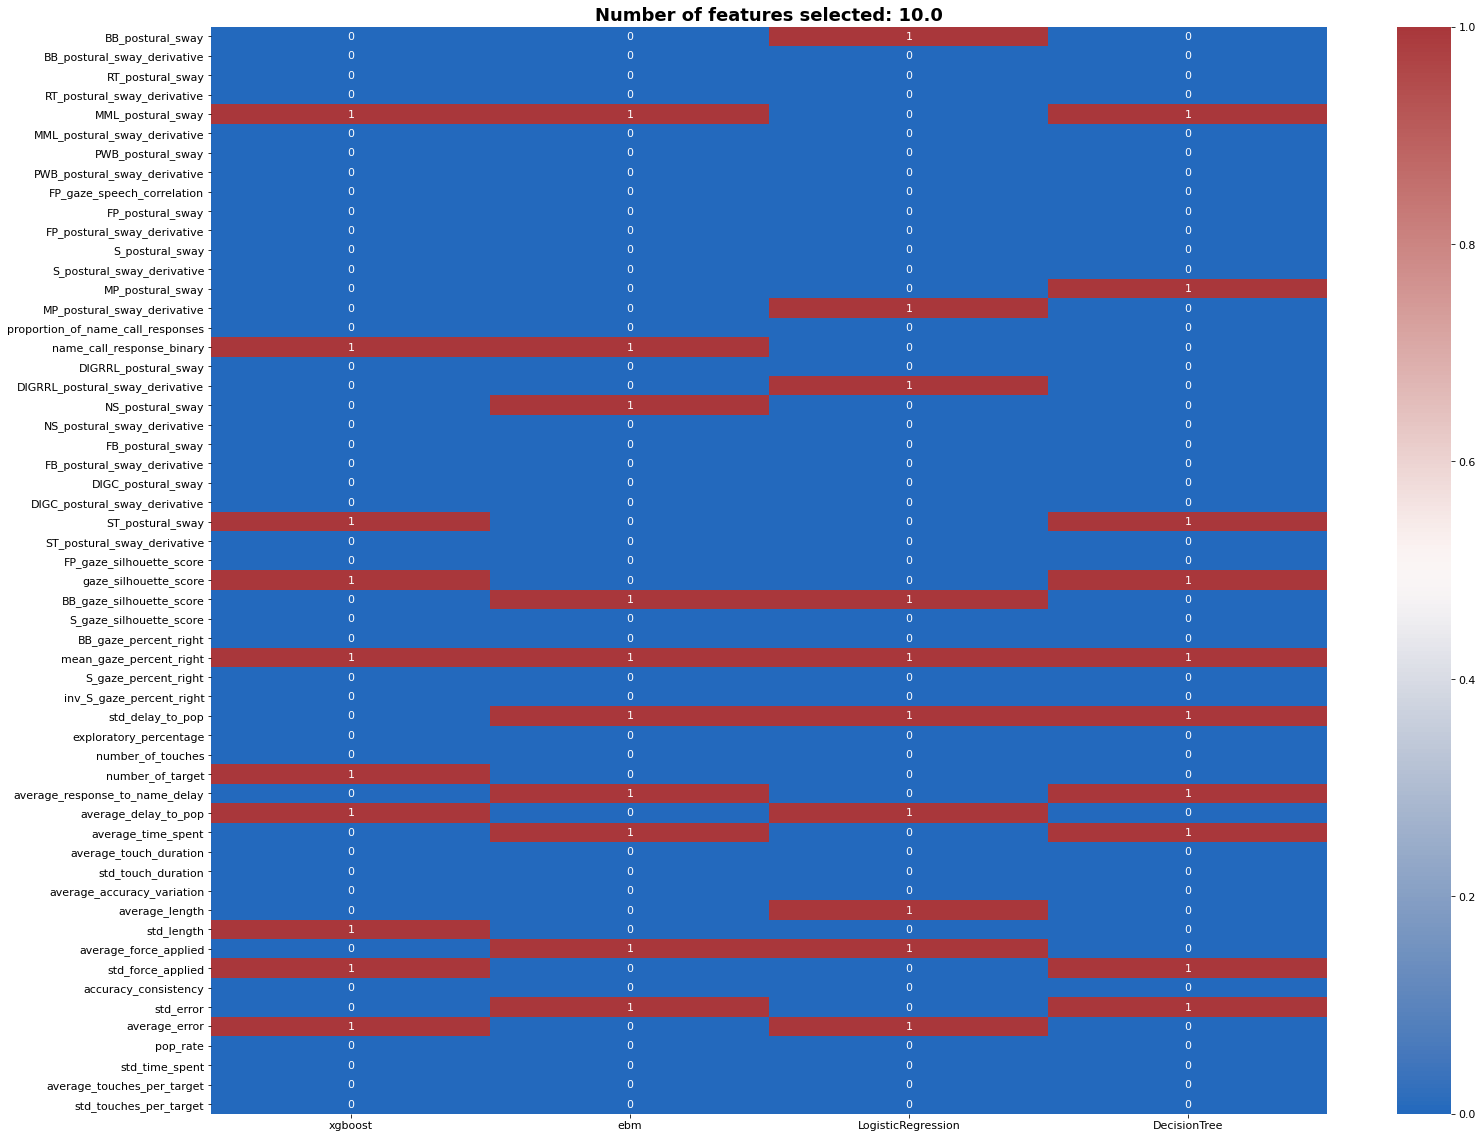

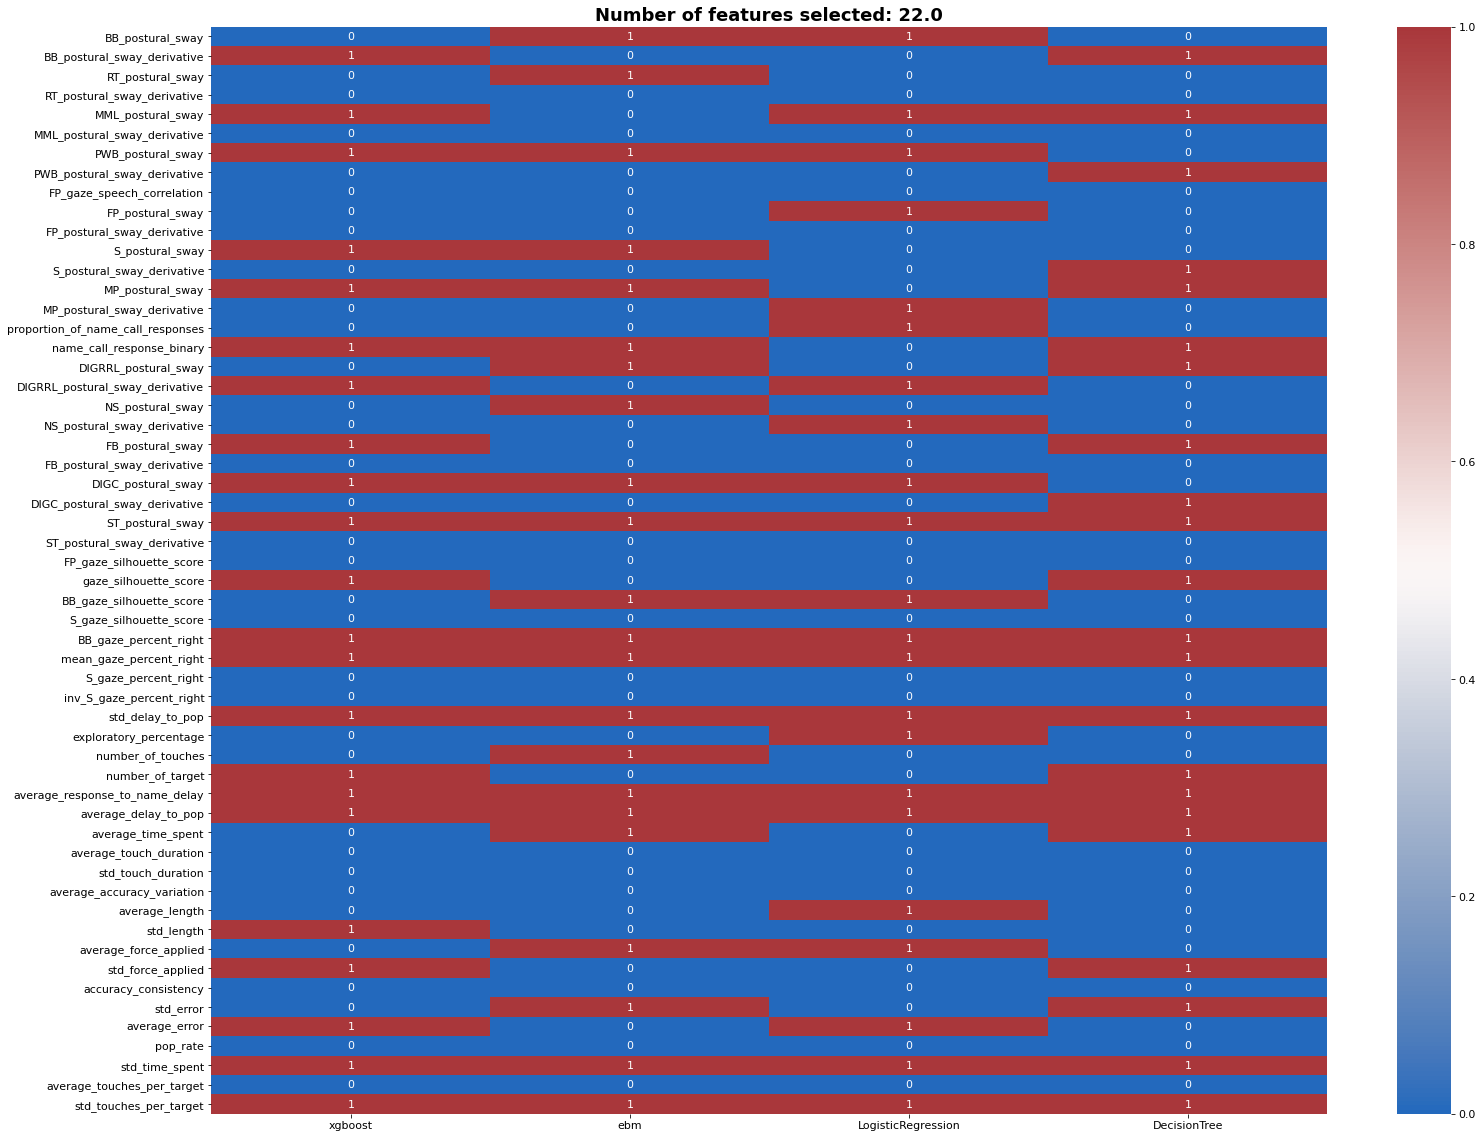

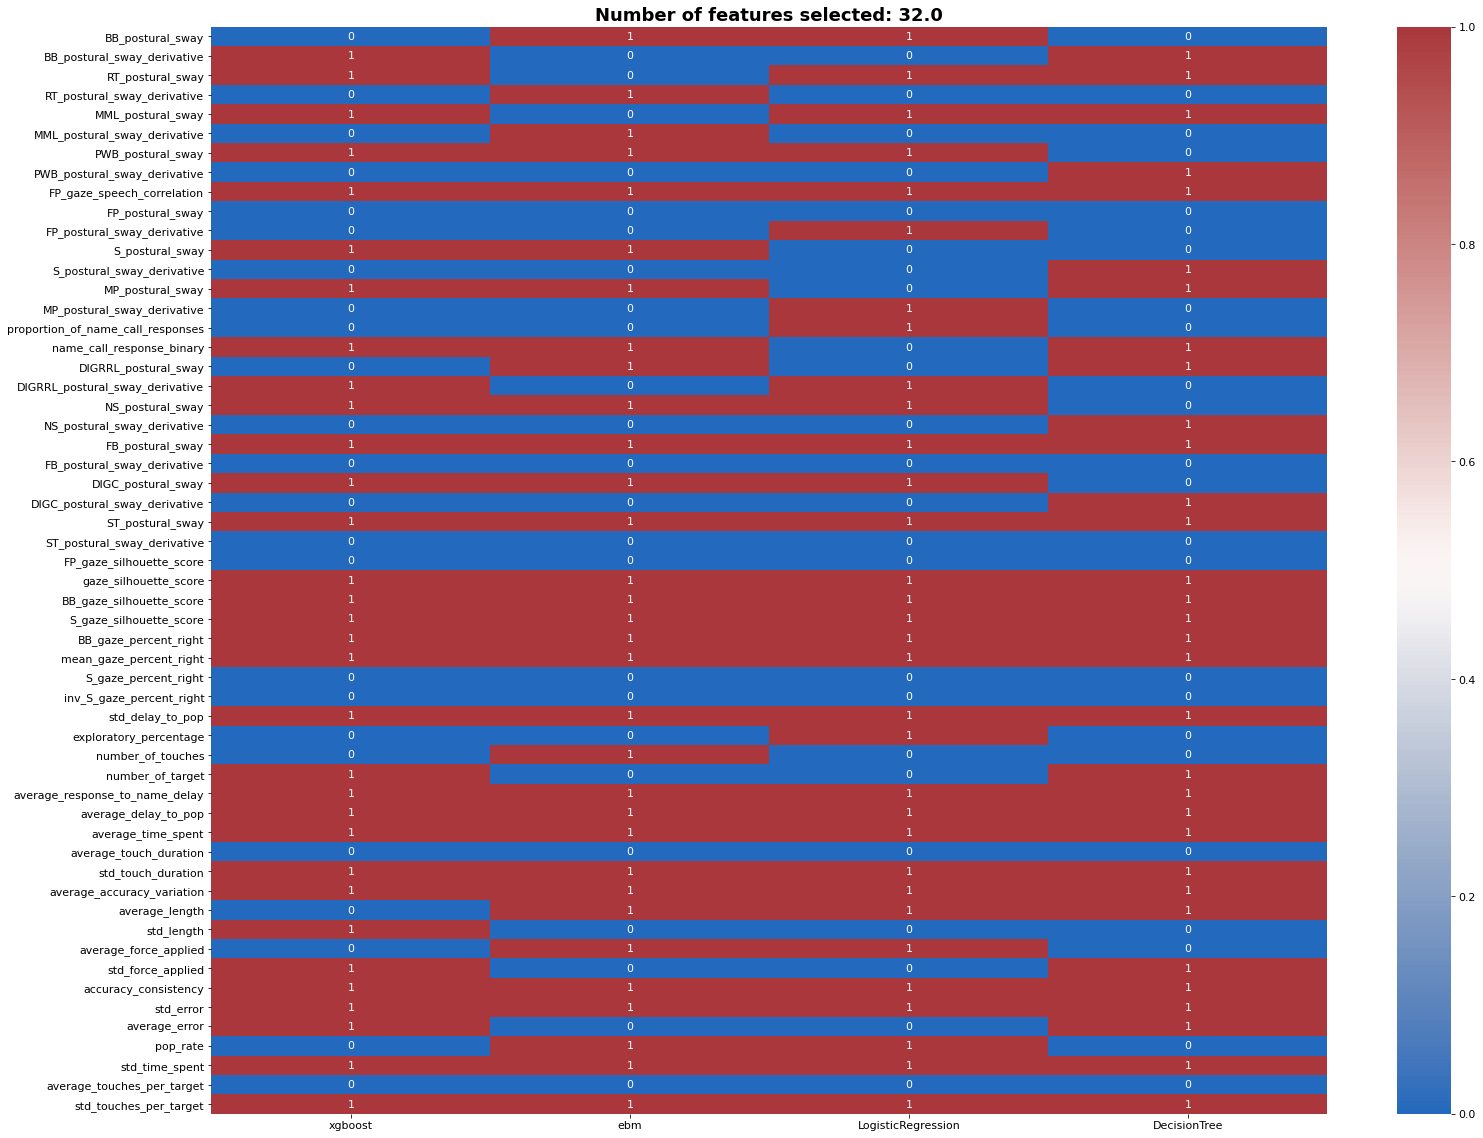

In [332]:
features_importance = pd.DataFrame(columns=dendro['ivl'])

for model, values in scenario_selected_features.items():
    
    for n_features, features_list in values.items():
        
        features_importance = features_importance.append(pd.DataFrame(np.array(list(np.ones(n_features)) + [n_features])[np.newaxis, :], columns = features_list + ['n_features'], index = [model]))
        
features_importance

for i, d in features_importance.groupby('n_features'):
    
    
    
    plt.figure(figsize=(25, 20))
    sns.heatmap(d.drop(columns=['n_features']).replace({np.nan:0}).transpose(), annot=True, cmap="vlag")
    plt.title("Number of features selected: {}".format(i), fontsize=18, weight='bold')
    plt.show()

# Annexe: 2D features selection and exploration

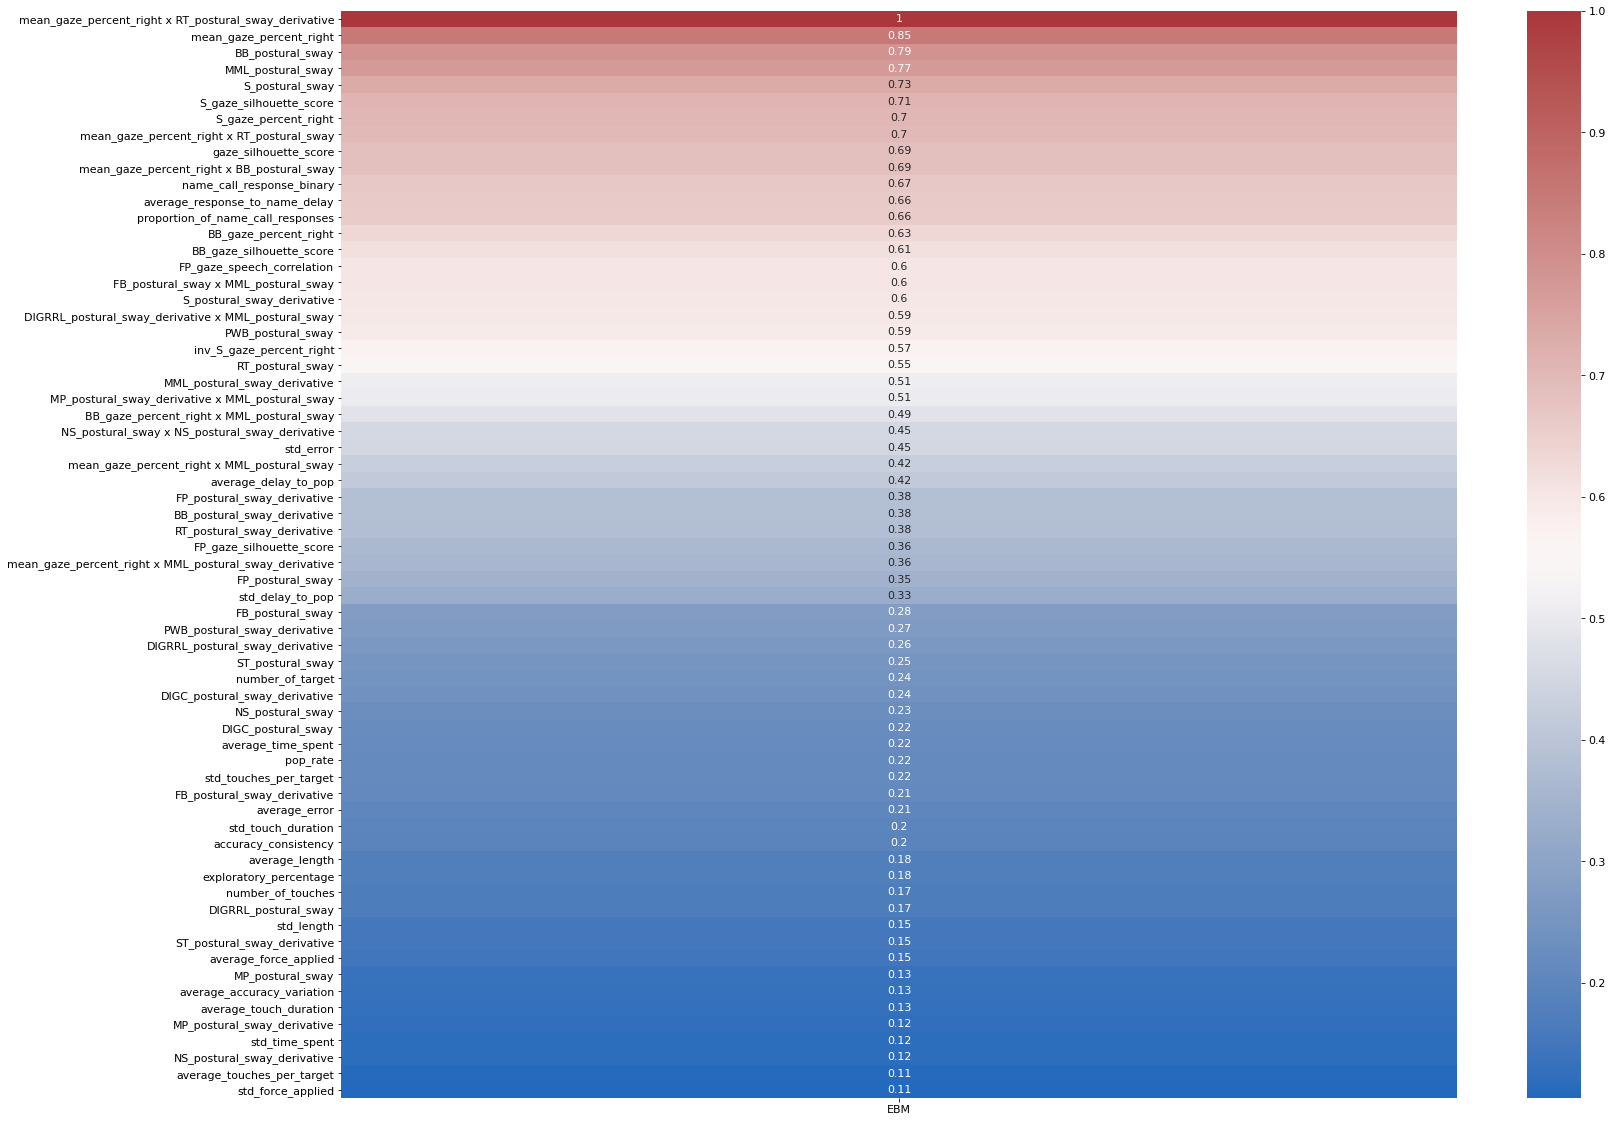

In [342]:
approach = 'ebm'
features = CVA_COLUMNS 
features = [f for f in features if f not in ['PB_postural_sway', 'PB_postural_sway_derivative', 'diagnosis']]
scenario = 'papers'


from interpret.glassbox import ExplainableBoostingClassifier


df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = features, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=scenario,
               proportion_train=1)

exp = Experiments(data.dataset_name,
              dataset=data, 
                approach=approach, 
                previous_experiment=None,        
                verbosity=0, 
                debug=True, 
                save_experiment=False)




exp.model = ExplainableBoostingClassifier(feature_names=exp.features_name, 
                                            max_bins=256,
                                            max_interaction_bins=32,
                                            binning='quantile',
                                            mains='all',
                                            interactions=10,
                                            outer_bags=8,
                                            inner_bags=0,
                                            learning_rate=0.01,
                                            validation_size=0.15,
                                            early_stopping_rounds=50,
                                            early_stopping_tolerance=0.0001,
                                            max_rounds=5000,
                                            min_samples_leaf=2,
                                            max_leaves=3,
                                            n_jobs=4,
                                            random_state=RANDOM_STATE)

exp.fit()

ebm_global = exp.model.explain_global()
scenario_feature_importance = pd.DataFrame(np.array(ebm_global._internal_obj['overall']['scores'])[np.newaxis, :], columns=ebm_global.feature_names, index=['EBM'])
scenario_feature_importance = scenario_feature_importance/scenario_feature_importance.max().max()

plt.figure(figsize=(25, 20))
sns.heatmap(scenario_feature_importance.transpose().sort_values(by='EBM', ascending=False), annot=True, cmap="vlag")
plt.show()

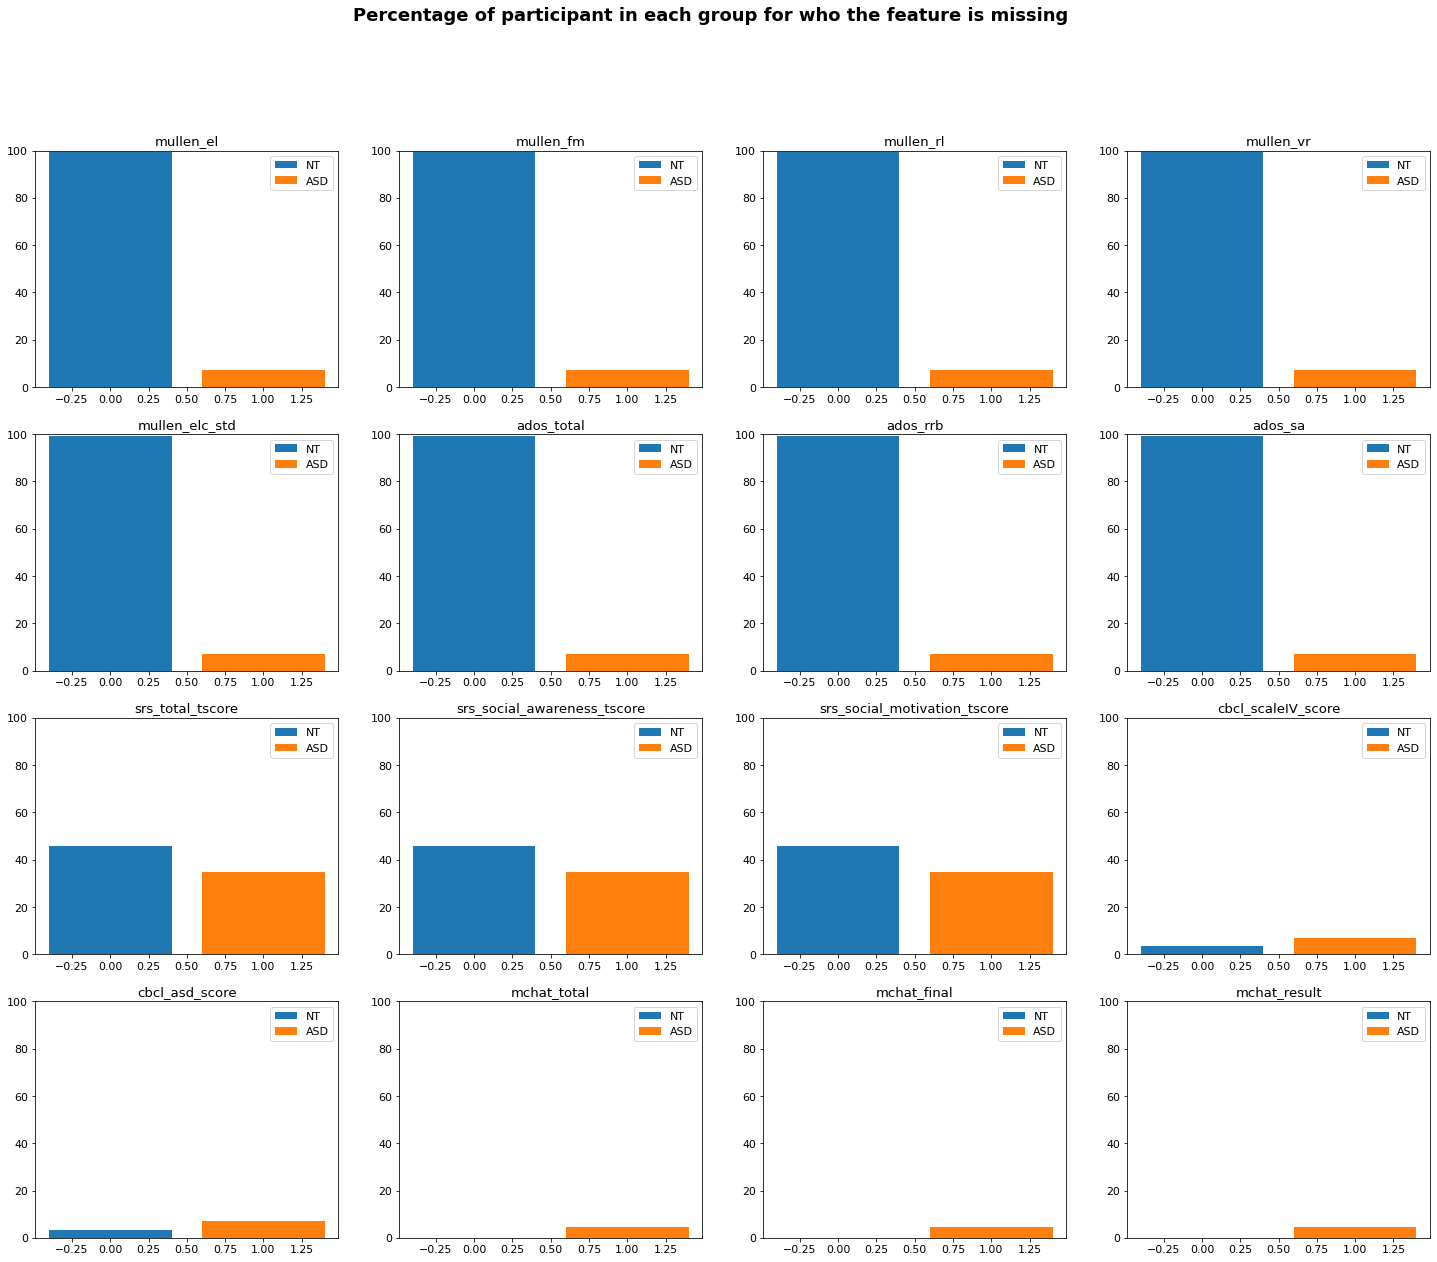

In [333]:
features = CLINICAL_COLUMNS[1:]

fig, axes = plt.subplots(len(features)//4, 4, figsize=(25, 20));axes=axes.flatten()
fig.suptitle("Percentage of participant in each group for who the feature is missing", fontsize=18, weight='bold')
for i, feat in enumerate(features):
    
    asd_perc = data.df[data.df['diagnosis']==1][feat].isna().mean()*100
    nt_perc = data.df[data.df['diagnosis']==0][feat].isna().mean()*100
    
    #print("Feature: {} Perc. missing NT: {:.2f} ASD: {:.2f}".format(feat, nt_perc, asd_perc))
    
    axes[i].bar([0], nt_perc, color='tab:blue', label='NT')
    axes[i].bar([1], asd_perc, color='tab:orange', label='ASD')
    axes[i].legend();axes[i].set_title(feat);axes[i].set_ylim((0,100))

In [334]:
acceptable_features_clinical = ['age','srs_total_tscore','srs_social_awareness_tscore','srs_social_motivation_tscore','cbcl_scaleIV_score','cbcl_asd_score','mchat_final']#'mchat_total',,'mchat_result']

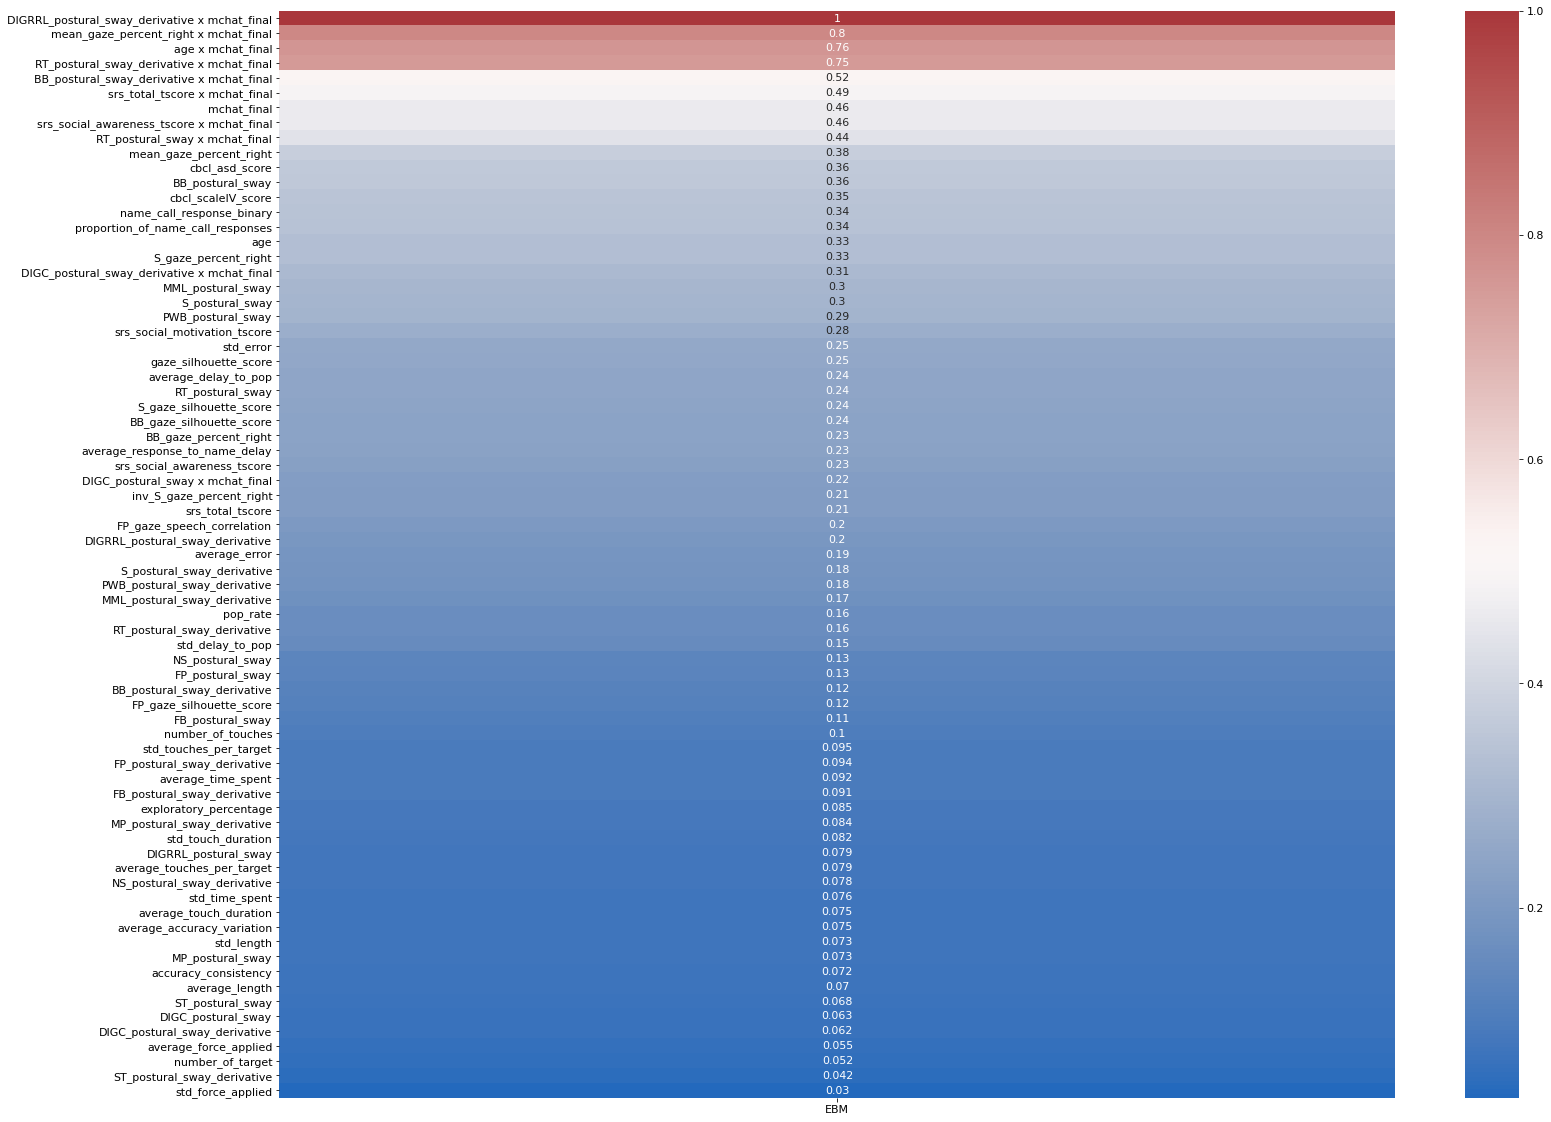

In [341]:
approach = 'ebm'
features = CVA_COLUMNS + acceptable_features_clinical
features = [f for f in features if f not in ['PB_postural_sway', 'PB_postural_sway_derivative', 'diagnosis']]
scenario = 'papers'

from interpret.glassbox import ExplainableBoostingClassifier

df =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = features, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=0,
               scenario=scenario,
               proportion_train=1)

exp = Experiments(data.dataset_name,
              dataset=data, 
                approach=approach, 
                previous_experiment=None,        
                verbosity=0, 
                debug=True, 
                save_experiment=False)

exp.model = ExplainableBoostingClassifier(feature_names=exp.features_name, 
                                            max_bins=256,
                                            max_interaction_bins=32,
                                            binning='quantile',
                                            mains='all',
                                            interactions=10,
                                            outer_bags=8,
                                            inner_bags=0,
                                            learning_rate=0.01,
                                            validation_size=0.15,
                                            early_stopping_rounds=50,
                                            early_stopping_tolerance=0.0001,
                                            max_rounds=5000,
                                            min_samples_leaf=2,
                                            max_leaves=3,
                                            n_jobs=4,
                                            random_state=RANDOM_STATE)

exp.fit()

ebm_global = exp.model.explain_global()
scenario_feature_importance = pd.DataFrame(np.array(ebm_global._internal_obj['overall']['scores'])[np.newaxis, :], columns=ebm_global.feature_names, index=['EBM'])
scenario_feature_importance = scenario_feature_importance/scenario_feature_importance.max().max()

plt.figure(figsize=(25, 20))
sns.heatmap(scenario_feature_importance.transpose().sort_values(by='EBM', ascending=False), annot=True, cmap="vlag")
plt.show()